## COMP5625M Deep Learning - Practical Assessment [100 Marks]


<div class="logos"><img src="Comp5625M_logo.jpg" width="220px" align="right"></div>

This assessment is divided into two parts:
> 1. Image classification using a convolutional neural network (CNN), training your model, evaluating your model, understanding fine-tuning, handling overfitting  [60 Marks]
> 2. Use of a Recurrent Neural Network (RNN) to predict texts for image captioning, and use of large language models (LLMs) for this task [40 Marks]


The maximum number of marks for each part is shown in the section headers. As indicated in the main heading above, the overall assessment carries a maximum of 100 marks.

This summative assessment is weighted 50% of the final grade for the module.


### Motivation 

Through this coursework, you will:

> 1. Understand and implement a convolutional neural network (CNN) and see how this can be used for a classification problem. 
> 2. Practice building, evaluating, and finetuning your CNN on an image dataset from development to testing stage. 
> 3. You will learn to tackle overfitting problem using strategies such as data augmentation and drop out.
> 4. Compare your model performance and accuracy with others, such as the leaderboard on Kaggle.
> 5. Use a Recurrent Neural Network (RNN) to predict the caption of an image from established word vocabularies.
> 6. Understand and visualise text predictions for a given image.
> 7. Learn to use transformers for image embedding and transformer-based large language models for text embedding learning.


### Setup and resources 

You must work using this provided template notebook.

Having a GPU will speed up the training process. See the provided document on Minerva about setting up a working environment for various ways to access a GPU.

Please implement the coursework using **Python and PyTorch**, and refer to the notebooks and exercises provided.


### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, without removing anything in the template, in **.ipynb format.**
> 2. The **.html version** of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) displayed in the .html for marking.
> 3. Your selected image from section 2.4.2 "Failure analysis"

Final note:

> **Please display everything that you would like to be marked. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.


Your student username (for example, ```sc15jb```): 

sc21nl

Your full name: 

Natalie Leung

### Part I: Image Classification [60 marks]

#### Dataset
This coursework will use a subset of images from Tiny ImageNet, which is a subset of the [ImageNet dataset](https://www.image-net.org/update-mar-11-2021.php). Our subset of Tiny ImageNet contains **30 different categories**, we will refer to it as TinyImageNet30. The training set has 450 resized images (64x64 pixels) for each category (13,500 images in total). You can download the training and test set from the Kaggle website:

>[Direct access of data is possible by clicking here, please use your university email to access this](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/ESF87mN6kelIkjdISkaRow8BublW27jB-P8eWV6Rr4rxtw?e=SPASDB)

>[Please click here to submit your results on the Kaggle competition. -- You can also access data here](https://www.kaggle.com/t/d77d518158104932a434a8954ec9ebc2)

To access the dataset, you will need an account on the Kaggle website. Even if you have an existing Kaggle account, please carefully adhere to these instructions, or we may not be able to locate your entries:

> 1. Use your **university email** to register a new account.
> 2. Set your **Kaggle account NAME** to your university username, for example, ``sc15jb`` (see the ``note`` below)

``Note:`` If the name is already taken in Kaggle then please use a similar pseudo name and add a note in your submission with the name you have used in Kaggle. 

#### Submitting your test result to Kaggle leaderboard 
The class Kaggle competition also includes a blind test set, which will be used in Question 1 for evaluating your custom model's performance on a test set. The competition website will compute the test set accuracy, as well as position your model on the class leaderboard. More information is provided in the related section below.


## Required packages

[1] [numpy](http://www.numpy.org) is package for scientific computing with python

[2] [h5py](http://www.h5py.org) is package to interact with compactly stored dataset

[3] [matplotlib](http://matplotlib.org) can be used for plotting graphs in python

[4] [pytorch](https://pytorch.org/docs/stable/index.html) is library widely used for bulding deep-learning frameworks

Feel free to add to this section as needed. Examples for importing some libraries is provided for you below.

You may need to install these packages using [pip](https://pypi.org/project/opencv-python/) or [conda](https://anaconda.org/conda-forge/opencv).

In [ ]:
import os
import math
import copy
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from natsort import natsorted

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torch.hub import load_state_dict_from_url

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import models

from sklearn.metrics import confusion_matrix, roc_curve, auc


In [149]:
# always check your version
print(torch.__version__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

2.2.1
Using device: cpu


One challenge of building a deep learning model is to choose an architecture that can learn the features in the dataset without being unnecessarily complex. The first part of the coursework involves building a CNN and training it on TinyImageNet30. 

### **Overview of image classification:**

**1. Function implementation** [10 marks]

*   **1.1** PyTorch ```Dataset``` and ```DataLoader``` classes (4 marks)
*   **1.2** PyTorch ```Model``` class for 5-layer CNN model (6 marks)

**2. Model training** [24 marks]
*   **2.1** Training on TinyImageNet30 dataset (6 marks)
*   **2.2** Generating confusion matrices and ROC curves (6 marks)
*   **2.3** Strategies for tackling overfitting (12 marks)
    *   **2.3.1** Data augmentation
    *   **2.3.2** Dropout
    *   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)
            
**3. Model testing** [10 marks]
*   **3.1**   Testing your final model in (2) on test set - code to do this (4 marks)
*   **3.2**   Uploading your result to Kaggle  (6 marks)

**4. Model Fine-tuning on CIFAR10 dataset** [16 marks]
*   **4.1** Fine-tuning your model (initialise your model with pretrained weights from (2)) (6 marks)
*   **4.2** Fine-tuning model with frozen base convolution layers (6 marks)
*   **4.3** Compare complete model retraining with pretrained weights and with frozen layers. Comment on what you observe. (4 marks) 


<!-- **5. Model comparison** [16 marks]
*   **5.1**   Load pretrained AlexNet and finetune on TinyImageNet30 until model convergence (8 marks)
*   **5.2**   Compare the results of your model with pretrained AlexNet on the same validation set. Provide performance values (loss graph, confusion matrix, top-1 accuracy, execution time) (8 marks) -->
<!-- 
**6. Interpretation of results** (14 marks)
*   **6.1** Implement grad-CAM for your model and AlexNet (6 marks)
*   **6.2** Visualise and compare your results from your model and AlexNet (4 marks)
*   **6.3** Provide comment on (4 marks)
    - why the network predictions were correct or not correct in your predictions? 
    - what can you do to improve your results further?

**7. Residual connection for deeper network** (9 marks)
*   **7.1** Implement a few residual layers in AlexNet and retrain on TinyImageNet30. You can change network size if you wish. (6 marks)
*   **7.2** Comment on why such connections are important and why this impacted your results in terms of loss and accuracy (if it did!) (3 marks)

**Quality of your report** (2 marks) -->


## 1 Implement a CNN network and dataset class [10 marks]


### 1.1 Dataset class (4 marks)

Write a PyTorch ```Dataset``` class (an example [here](https://www.askpython.com/python-modules/pytorch-custom-datasets) for reference) which loads the TinyImage30 dataset and ```DataLoaders``` for training and validation sets.

In [150]:
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import os
from PIL import Image
from natsort import natsorted

# Define paths
dataset_dir = "./comp5625M_data_assessment_1"
train_data_path = os.path.join(dataset_dir, "train_set/train_set")
test_data_path = os.path.join(dataset_dir, "test_set/test_set")

class TinyImageNetDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Iterate through class directories to store image paths and labels
        for label in sorted(os.listdir(root_dir)):  # Sort ensures consistent class indices
            label_path = os.path.join(root_dir, label)
            if os.path.isdir(label_path):
                for img_file in natsorted(os.listdir(label_path)):
                    img_path = os.path.join(label_path, img_file)
                    self.image_paths.append(img_path)
                    self.labels.append(label)
        
        # Convert labels to indices
        self.label_to_idx = {label: idx for idx, label in enumerate(sorted(set(self.labels)))}
        self.labels = [self.label_to_idx[label] for label in self.labels]

    # The length of the dataset
    def __len__(self):
        return len(self.image_paths)
    
    # Load of item in folder
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Load image using PIL
        image = Image.open(img_path).convert("RGB")

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label


In [151]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to 64x64 pixels
    transforms.ToTensor(),        # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Load dataset AFTER extraction
train_dataset = TinyImageNetDataset(root_dir=train_data_path, transform=transform)
val_dataset = TinyImageNetDataset(root_dir=test_data_path, transform=transform)

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Dataset loaded successfully!")


Dataset loaded successfully!


### 1.2 Define a CNN model class (6 marks)

<u>Create a new model class using a combination of:</u>
- Convolution layers
- Activation functions (e.g. ReLU)
- Maxpooling layers
- Fully connected layers 
- Loss function
- Optimiser

*Please note that the network should be at least a few layers for the model to perform well.*

In [152]:
import torch
import torch.nn as nn
import torch.optim as optim

class CNNModel(nn.Module):
    def __init__(self, num_classes=30):
        super(CNNModel, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        # Activation function
        self.relu = nn.ReLU()
        
        # Max Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)
        
        # Softmax for classification
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x  # No Softmax!
    
model = CNNModel(num_classes=30)  # Instantiate the model
torch.save(model.state_dict(), "cnn_model.pth") 
               
# Loss function and optimizer
def get_loss_and_optimizer(model, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return criterion, optimizer


if __name__ == "__main__":
    print("CNN model definition script ready.")



CNN model definition script ready.


## 2 Model training [24 marks]


### 2.1 Train both MLP and CNN model - show loss and accuracy graphs side by side (6 marks)

Train your model on the TinyImageNet30 dataset. Split the data into train and validation sets to determine when to stop training. Use seed at 0 for reproducibility and test_ratio=0.2 (validation data)

Display the graph of training and validation loss over epochs and accuracy over epochs to show how you determined the optimal number of training epochs. A top-*k* accuracy implementation is provided for you below.

> Please leave the graph clearly displayed. Please use the same graph to plot graphs for both train and validation.


In [153]:
# (HelperDL function) -- Define top-*k* accuracy (**new**)
def topk_accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [156]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLPModel(nn.Module):
    def __init__(self, input_size=64*64*3, hidden_size=256, output_size=30):
        super(MLPModel, self).__init__()

        # Fully connected layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        """
        Forward pass for the MLP model
        """
        x = x.view(x.size(0), -1)  # Flatten input image
        x = F.relu(self.fc1(x))  # First hidden layer + ReLU activation
        x = self.dropout(x)
        x = F.relu(self.fc2(x))  # Second hidden layer + ReLU activation
        x = self.dropout(x)
        x = self.fc3(x)  # Output layer
        return x
    
# Initialize model
model = MLPModel()

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("MLP model initialized successfully!")



MLP model initialized successfully!


In [157]:
# Set seed for reproducibility
torch.manual_seed(0)

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define dataset split (80% training, 20% validation)
test_ratio = 0.2
total_size = len(train_dataset)
val_size = int(test_ratio * total_size)
train_size = total_size - val_size

# Perform dataset split
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(f"Dataset split: {train_size} training samples, {val_size} validation samples")

# Initialize model
model = MLPModel().to(device)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Store training and validation losses/accuracies
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute training metrics
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Compute average loss and accuracy for training
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    # Validation phase
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}% - "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

print("Training completed!")

Dataset split: 8640 training samples, 2160 validation samples
Epoch 1/20 - Train Loss: 3.2746, Train Acc: 10.13% - Val Loss: 3.0517, Val Acc: 13.52%
Epoch 2/20 - Train Loss: 3.0318, Train Acc: 14.38% - Val Loss: 2.9944, Val Acc: 15.19%
Epoch 3/20 - Train Loss: 2.9415, Train Acc: 16.19% - Val Loss: 2.9244, Val Acc: 17.08%
Epoch 4/20 - Train Loss: 2.8691, Train Acc: 17.93% - Val Loss: 2.8861, Val Acc: 18.89%
Epoch 5/20 - Train Loss: 2.8116, Train Acc: 19.44% - Val Loss: 2.9119, Val Acc: 19.07%
Epoch 6/20 - Train Loss: 2.7545, Train Acc: 21.19% - Val Loss: 2.8837, Val Acc: 19.86%
Epoch 7/20 - Train Loss: 2.6887, Train Acc: 22.94% - Val Loss: 2.8880, Val Acc: 18.10%
Epoch 8/20 - Train Loss: 2.6433, Train Acc: 24.11% - Val Loss: 2.8908, Val Acc: 18.52%
Epoch 9/20 - Train Loss: 2.5745, Train Acc: 25.51% - Val Loss: 2.8972, Val Acc: 19.72%
Epoch 10/20 - Train Loss: 2.5251, Train Acc: 26.88% - Val Loss: 2.9113, Val Acc: 18.84%
Epoch 11/20 - Train Loss: 2.4801, Train Acc: 28.17% - Val Loss: 2.9

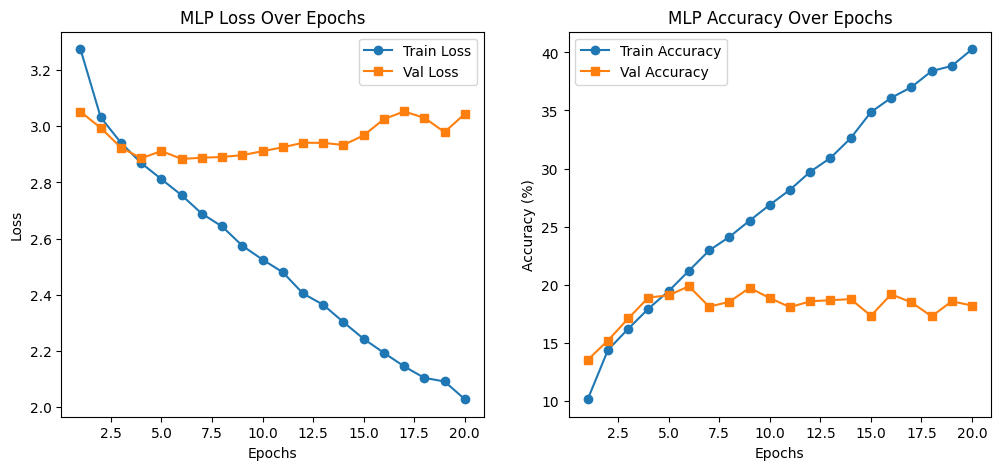

In [158]:
# Plot loss and accuracy graphs
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot loss
axs[0].plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker="o")
axs[0].plot(range(1, num_epochs+1), val_losses, label="Val Loss", marker="s")
axs[0].set_title("MLP Loss Over Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

# Plot accuracy
axs[1].plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker="o")
axs[1].plot(range(1, num_epochs+1), val_accuracies, label="Val Accuracy", marker="s")
axs[1].set_title("MLP Accuracy Over Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy (%)")
axs[1].legend()

plt.show()

In [ ]:
# CNN model
# Initialize the model
model = CNNModel(num_classes=30)

# Load saved model weights
model.load_state_dict(torch.load("cnn_model.pth", map_location=device))

# Move model to device
model.to(device)

# Set seed for reproducibility
torch.manual_seed(0)
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20, device='cuda'):
    model.to(device)
    train_losses, val_losses, train_acc, val_acc = [], [], [], []
    
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)
        
        train_losses.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)
        
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                correct += (outputs.argmax(dim=1) == labels).sum().item()
                total += labels.size(0)
        
        val_losses.append(running_loss / len(val_loader))
        val_acc.append(100 * correct / total)
        
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f} - Train Acc: {train_acc[-1]:.2f}% - Val Acc: {val_acc[-1]:.2f}%")
    
    return train_losses, val_losses, train_acc, val_acc

# Load CIFAR-10 Dataset for Training
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Model, Loss & Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel(num_classes=30)
criterion, optimizer = get_loss_and_optimizer(model)

# Train the model
train_losses, val_losses, train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20, device=device)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/20 - Train Loss: 1.5488 - Val Loss: 1.3227 - Train Acc: 44.44% - Val Acc: 52.23%
Epoch 2/20 - Train Loss: 1.1607 - Val Loss: 1.1178 - Train Acc: 59.15% - Val Acc: 60.51%
Epoch 3/20 - Train Loss: 1.0174 - Val Loss: 1.0750 - Train Acc: 64.36% - Val Acc: 61.83%
Epoch 4/20 - Train Loss: 0.9147 - Val Loss: 0.9401 - Train Acc: 68.11% - Val Acc: 67.27%
Epoch 5/20 - Train Loss: 0.8388 - Val Loss: 0.9518 - Train Acc: 70.87% - Val Acc: 67.22%
Epoch 6/20 - Train Loss: 0.7758 - Val Loss: 0.8944 - Train Acc: 73.02% - Val Acc: 68.95%
Epoch 7/20 - Train Loss: 0.7166 - Val Loss: 0.9169 - Train Acc: 75.08% - Val Acc: 69.10%
Epoch 8/20 - Train Loss: 0.6666 - Val Loss: 0.8836 - Train Acc: 76.65% - Val Acc: 70.51%
Epoch 9/20 - Train Loss: 0.6158 - Val Loss: 0.9053 - Train Acc: 78.58% - Val Acc: 70.10%
Epoch 10/20 - Train Loss: 0.5647 - Val Loss: 0.8907 - Train Acc: 80.14% - Val Acc: 70.92%
Epoch 11/20 - Train Loss: 0.5234 

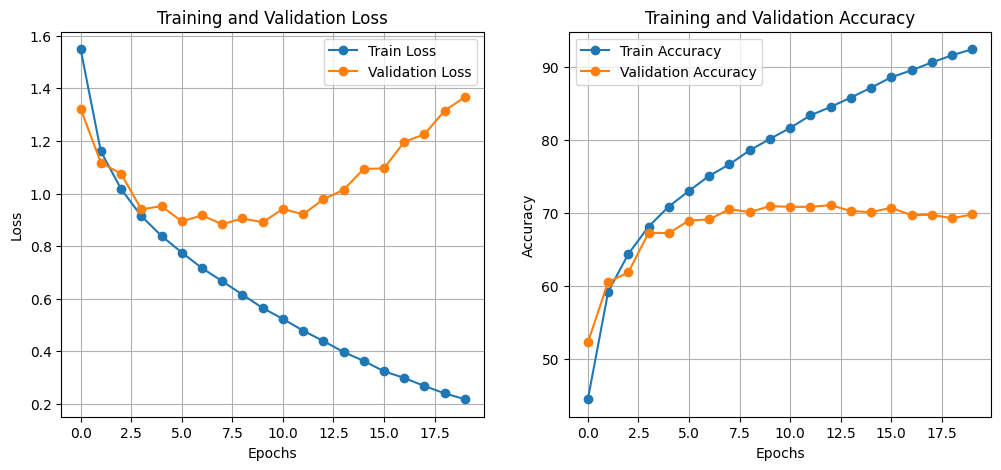

In [160]:
# Function to plot training and validation loss and accuracy
def plot_results(train_losses, val_losses, train_acc, val_acc):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy', marker='o')
    plt.plot(val_acc, label='Validation Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()
    
plot_results(train_losses, val_losses, train_acc, val_acc)


> Comment on your model and the results you have obtained. This should include the number of parameters for each of your models and briefly explain why one should use CNN over MLP for the image classification problem.

The MLP architecture used a fully connected architecture that flattened 64x64x3 input and passed it through two hidden layers of 256 units. It results in a total of around 3.3 million parameters. However, the CNN model used two convolutional layers with max pooling and two fully connected layers, resulting in 547,678 parameters.

The training accuracy of MLP was around 40% while the validation accuracy was only near 20%. The validation loss also remained relatively high, with a big gap between training and validation performance. It shows that the model is overfitting and has poor generalisation. On the other hand, CNN had a training accuracy higher than 90% and the accuracy of validation was around 70%. The training and validation loss were also lower than NLP, which shows that the CNN generalised better than NLP. Although, the validation accuracy and validation loss indicate that the CNN might be overfitting, CNN still has a better performance.

The CNN performed better because it is designed to learn and recognise patterns. In convolutional filters, they allow the network to detect patterns like edges and texture while preserving spatial structure. It is also more efficient because of the weight sharing in the convolutional layers. However, MLP flattens the image and treats each pixel as independent, which leads to a loss of spatial information and a higher number of parameters. These lead to overfitting easily. 

In conclusion, CNN has a better accuracy and generalisation with a lower loss than MLP. 


### 2.2 Generating confusion matrix and ROC curves (6 marks)
- Use your CNN architecture with best accuracy to generate two confusion matrices, one for the training set and another for the validation set. Remember to use the whole validation and training sets, and to include all your relevant code. Display the confusion matrices in a meaningful way which clearly indicates what percentage of the data is represented in each position.
- Display an ROC curve for the two top and two bottom classes with area under the curve

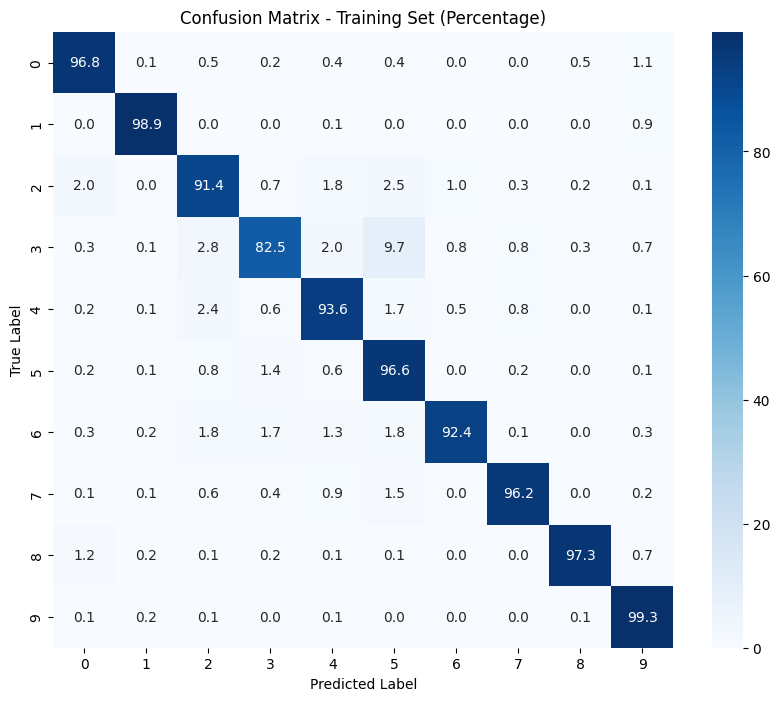

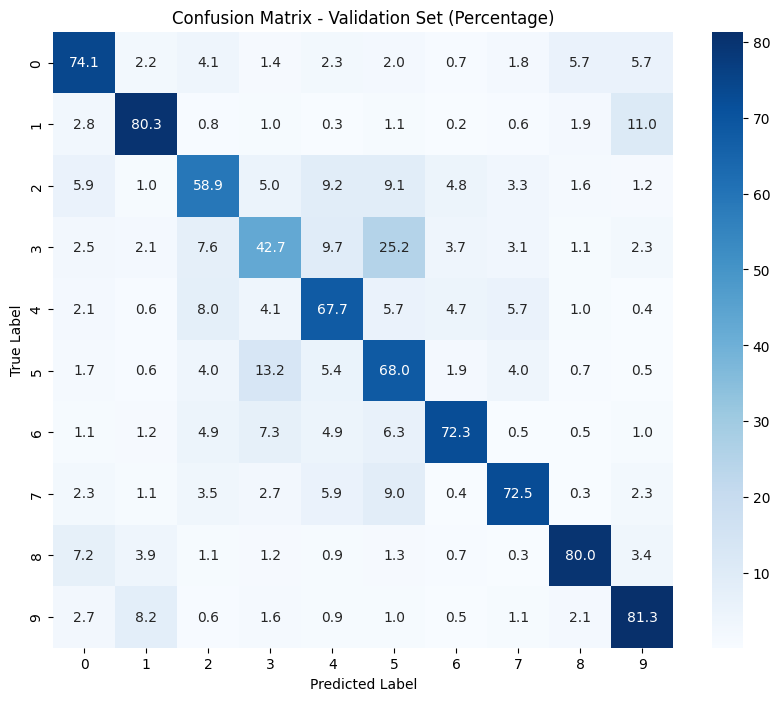

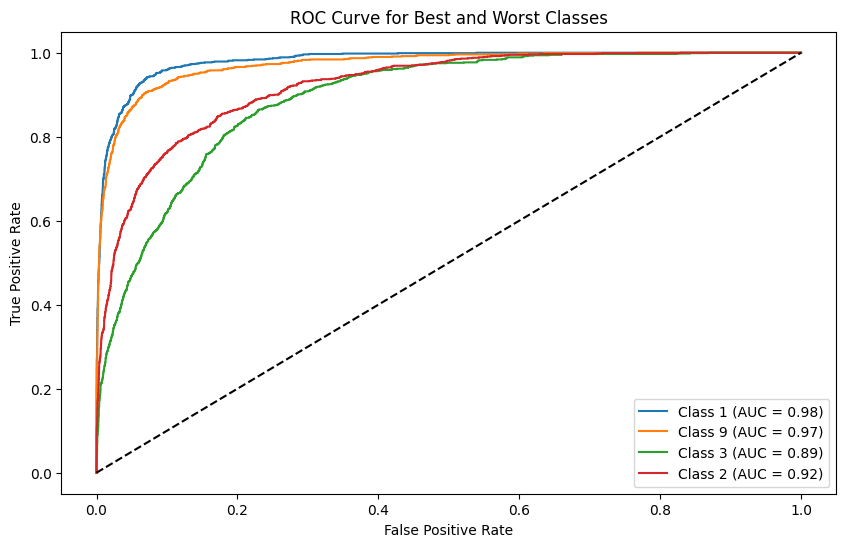

In [ ]:
# Ensure model is in evaluation mode
model.eval()

# Function to get predictions, true labels, and probabilities
def get_predictions_and_labels(model, dataloader, device):
    all_preds, all_labels, all_probs = [], [], []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
            
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

# Get predictions for training and validation sets
train_preds, train_labels, train_probs = get_predictions_and_labels(model, train_loader, device)
val_preds, val_labels, val_probs = get_predictions_and_labels(model, val_loader, device)

# Generate confusion matrices
train_cm = confusion_matrix(train_labels, train_preds)
val_cm = confusion_matrix(val_labels, val_preds)

# Function to plot confusion matrix with percentages
def plot_confusion_matrix(cm, title, class_names):
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentages
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_percentage, annot=True, fmt=".1f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

# Get class names dynamically
num_classes = train_cm.shape[0]
class_names = [str(i) for i in range(num_classes)]

# Plot confusion matrices
plot_confusion_matrix(train_cm, "Confusion Matrix - Training Set (Percentage)", class_names)
plot_confusion_matrix(val_cm, "Confusion Matrix - Validation Set (Percentage)", class_names)

# Compute class-wise accuracy
class_accuracy = np.diag(val_cm) / np.sum(val_cm, axis=1)
sorted_classes = np.argsort(class_accuracy)  # Sort classes by accuracy

# Select two best and two worst classes
best_classes = sorted_classes[-2:]  # Highest accuracy
worst_classes = sorted_classes[:2]  # Lowest accuracy
selected_classes = np.concatenate((best_classes, worst_classes))

# Generate ROC curves for selected classes
plt.figure(figsize=(10, 6))

for cls in selected_classes:
    binary_labels = (val_labels == cls).astype(int)  # Convert labels to binary (1 for class `cls`, 0 for others)
    binary_preds = val_probs[:, cls]  # Probability scores for class `cls`
    
    fpr, tpr, _ = roc_curve(binary_labels, binary_preds)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"Class {cls} (AUC = {roc_auc:.2f})")

# Plot ROC curve
plt.plot([0, 1], [0, 1], "k--")  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Best and Worst Classes")
plt.legend()
plt.show()


### 2.3 Strategies for tackling overfitting (12 marks)
Using your (final) CNN model perform the strategies below to avoid overfitting problems. You can reuse the network weights from previous training, often referred to as ``fine tuning``. 
*   **2.3.1** Data augmentation
*   **2.3.2** Dropout
*   **2.3.3** Hyperparameter tuning (e.g. changing learning rate)

> Plot loss and accuracy graphs per epoch side by side for each implemented strategy.

#### 2.3.1 Data augmentation (4 marks)

> Implement at least five different data augmentation techniques that should include both photometric and geometric augmentations. 

> Provide graphs and comment on what you observe.


Files already downloaded and verified


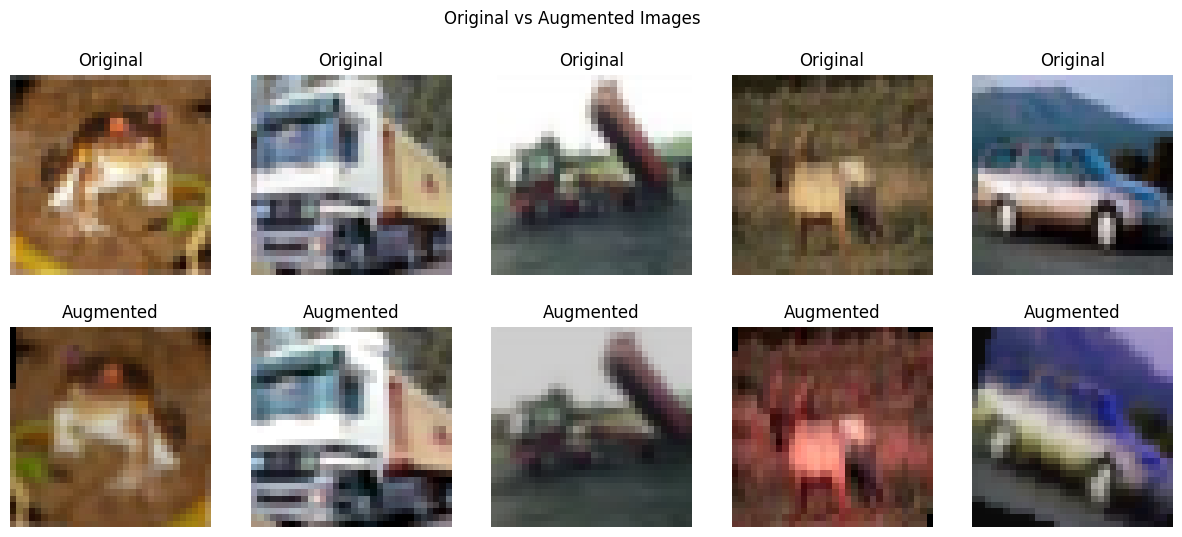

In [ ]:
# Define Data Augmentation Transformations
data_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),        # Horizontal Flip
    transforms.RandomRotation(20),                 # Random Rotation
    transforms.RandomResizedCrop(32, scale=(0.8, 1.0)),  # Random Resized Crop
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Color Jitter
    transforms.GaussianBlur(kernel_size=3),        # Gaussian Blur
    transforms.ToTensor()
])

# Load a small subset of CIFAR-10 dataset for visualization
dataset = datasets.CIFAR10(root='./data', train=True, download=True)

# Select a few sample images
sample_images = [dataset[i][0] for i in range(5)]  # Select 5 sample images

# Apply transformations and visualize
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, img in enumerate(sample_images):
    # Original Image (Top Row)
    axes[0, i].imshow(img)
    axes[0, i].axis("off")
    axes[0, i].set_title("Original")

    # Apply transformations
    augmented_img = data_transform(img)  # Apply transformation
    augmented_img = augmented_img.permute(1, 2, 0).numpy()  # Convert to numpy
    augmented_img = np.clip(augmented_img, 0, 1)  # Normalize

    # Augmented Image (Bottom Row)
    axes[1, i].imshow(augmented_img)
    axes[1, i].axis("off")
    axes[1, i].set_title("Augmented")

plt.suptitle("Original vs Augmented Images")
plt.show()

The data agrumentation aims to improve model generalisation and reduce overfitting. Geometric augmentation, such as horizontal flipping and random rotation, helps the model to recognise objects in different orientations. Moreover, photometric augmentations such as colour jitter, Gaussian Blur, and random crop enhancements enhance adaptability by showing objects in different brightnesses and contrasts.

#### 2.3.2 Dropout (4 marks)

> Implement dropout in your model.

> Provide graphs and comment on your choice of proportion used.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1/20 - Train Loss: 1.9328 - Val Loss: 1.6596 - Train Acc: 29.68% - Val Acc: 42.59%
Epoch 2/20 - Train Loss: 1.6673 - Val Loss: 1.5442 - Train Acc: 39.69% - Val Acc: 45.47%
Epoch 3/20 - Train Loss: 1.5835 - Val Loss: 1.4581 - Train Acc: 42.63% - Val Acc: 48.01%
Epoch 4/20 - Train Loss: 1.5337 - Val Loss: 1.4254 - Train Acc: 44.34% - Val Acc: 48.77%
Epoch 5/20 - Train Loss: 1.5041 - Val Loss: 1.3774 - Train Acc: 45.34% - Val Acc: 51.20%
Epoch 6/20 - Train Loss: 1.4757 - Val Loss: 1.3636 - Train Acc: 46.76% - Val Acc: 51.47%
Epoch 7/20 - Train Loss: 1.4605 - Val Loss: 1.3427 - Train Acc: 47.17% - Val Acc: 52.42%
Epoch 8/20 - Train Loss: 1.4448 - Val Loss: 1.3166 - Train Acc: 47.36% - Val Acc: 52.73%
Epoch 9/20 - Train Loss: 1.4275 - Val Loss: 1.3197 - Train Acc: 48.21% - Val Acc: 53.12%
Epoch 10/20 - Train Loss: 1.4087 - Val Loss: 1.2933 - Train Acc: 48.81% - Val Acc: 54.06%
Epoch 11/20 - Train Loss: 1.3999 

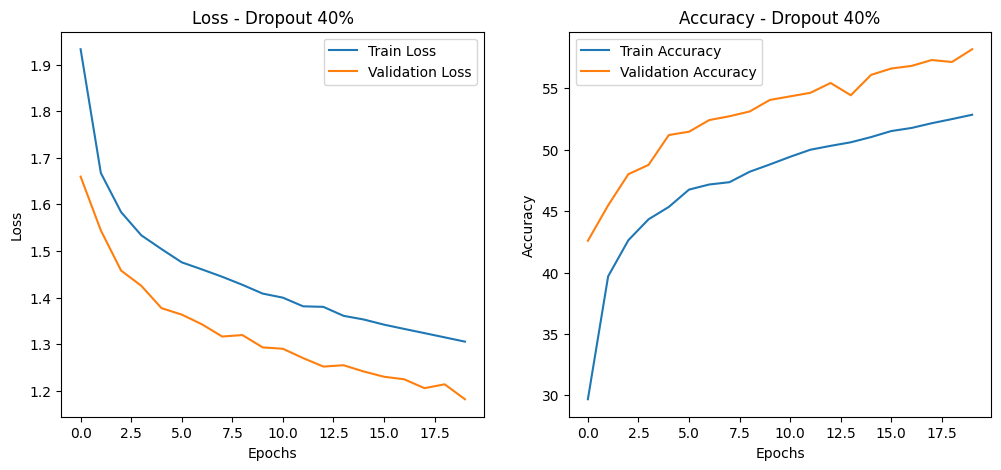

In [ ]:
# Define CNN Model with Dropout
class CNNModel(nn.Module):
    def __init__(self, num_classes=30, dropout_prob=0.4):  
        super(CNNModel, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        # Activation function
        self.relu = nn.ReLU()
        
        # Max Pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Dropout layer
        self.dropout = nn.Dropout(p=dropout_prob)

        # Fully connected layers
        self.flattened_size = None
        self.fc1 = None 
        self.fc2 = nn.Linear(128, num_classes)  # Output layer

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))

        # Dynamically determine input size for the fully connected layer
        if self.flattened_size is None:
            self.flattened_size = x.view(x.size(0), -1).shape[1]
            self.fc1 = nn.Linear(self.flattened_size, 128).to(x.device)  # Define FC1 dynamically
        
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))  # Apply FC1
        x = self.dropout(x)  # Apply Dropout before output
        x = self.fc2(x)  # Final Output Layer
        return x

# Define Training Function
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20, device='cuda'):
    model.to(device)
    train_losses, val_losses, train_acc, val_acc = [], [], [], []
    
    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)
        
        train_losses.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)
        
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                correct += (outputs.argmax(dim=1) == labels).sum().item()
                total += labels.size(0)
        
        val_losses.append(running_loss / len(val_loader))
        val_acc.append(100 * correct / total)
        
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f} - Train Acc: {train_acc[-1]:.2f}% - Val Acc: {val_acc[-1]:.2f}%")
    
    return train_losses, val_losses, train_acc, val_acc

# Load CIFAR-10 Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Train Model with Dropout
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.classes)
model = CNNModel(num_classes=num_classes, dropout_prob=0.4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses, train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20, device=device)
torch.save(model.state_dict(), "./best_model.pth")

# Plot Loss and Accuracy
def plot_training_results(train_losses, val_losses, train_acc, val_acc, title):
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss - {title}")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"Accuracy - {title}")
    plt.legend()

    plt.show()

# Plot Results
plot_training_results(train_losses, val_losses, train_acc, val_acc, "Dropout 40%")


A dropout layer was added right after the first fully connected layer with a probability of 40%. During training, 40% of the neurons in that layer will be randomly deactivated so the network can learn to be more robust and learn generalised features. The choice of a 40% dropout rate is aimed at balancing regularisation strength. Lower rates may not be sufficient to prevent overfitting, while higher rates could affect learning. The 40% is to improve validation performance without slowing convergence or affecting training accuracy.

The loss graphs show a steady decrease for both training and validation loss which indicates an effective learning. The validation loss is lower than the previous CNN without dropout showing an improvement of the model. The validation accuracy closely follows the training accuracy, unlike the previous CNN model, it has been increasing steadily, showing that dropout helps to reduce overfitting. 


#### 2.3.3 Hyperparameter tuning (4 marks)

> Use learning rates [0.1, 0.001, 0.0001].

> Provide graphs each for loss and accuracy at three different learning rates in a single graph.

In [164]:
# Define CNN Model with BatchNorm and Dropout
class CNNModel(nn.Module):
    def __init__(self, num_classes=30, dropout_prob=0.4):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.dropout = nn.Dropout(p=dropout_prob)

        self.fc1 = nn.Linear(128 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Function to train model with a given learning rate
def train_model_lr(model, train_loader, val_loader, criterion, lr, epochs=50, device="cuda"):
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    train_losses, val_losses, train_acc, val_acc = [], [], [], []
    best_val_acc = 0
    patience = 3
    wait = 0

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

        train_losses.append(running_loss / len(train_loader))
        train_acc.append(100 * correct / total)

        # Validation
        model.eval()
        running_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                correct += (outputs.argmax(dim=1) == labels).sum().item()
                total += labels.size(0)

        val_losses.append(running_loss / len(val_loader))
        val_acc.append(100 * correct / total)
        scheduler.step()

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}% - Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc[-1]:.2f}%")

        if val_acc[-1] > best_val_acc:
            best_val_acc = val_acc[-1]
            torch.save(model.state_dict(), "cnn_model_best.pth")
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered.")
                break

    return train_losses, val_losses, train_acc, val_acc

# Augmentation and Normalization
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# Load CIFAR-10
full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
full_val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Use larger subset
train_subset = Subset(full_train_dataset, np.random.choice(len(full_train_dataset), 20000, replace=False))
val_subset = Subset(full_val_dataset, np.random.choice(len(full_val_dataset), 4000, replace=False))

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

# Train with different learning rates
learning_rates = [0.1, 0.001, 0.0001]
results = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()

for lr in learning_rates:
    print(f"\nTraining with Learning Rate: {lr}")
    model = CNNModel(num_classes=30, dropout_prob=0.4)
    train_losses, val_losses, train_acc, val_acc = train_model_lr(model, train_loader, val_loader, criterion, lr, epochs=50, device=device)
    results[lr] = (train_losses, val_losses, train_acc, val_acc)

print("Training completed. Best model saved as cnn_model_best.pth")


# Save the best model
torch.save(model.state_dict(), "cnn_model_best.pth")
print("Model saved as cnn_model_best.pth")


Files already downloaded and verified
Files already downloaded and verified

Training with Learning Rate: 0.1
Epoch 1/50 - Train Loss: 2.3644, Train Acc: 16.07% - Val Loss: 2.0478, Val Acc: 21.57%
Epoch 2/50 - Train Loss: 2.0685, Train Acc: 21.75% - Val Loss: 1.8740, Val Acc: 27.77%
Epoch 3/50 - Train Loss: 1.9265, Train Acc: 27.30% - Val Loss: 1.7513, Val Acc: 34.48%
Epoch 4/50 - Train Loss: 1.7970, Train Acc: 32.27% - Val Loss: 1.6393, Val Acc: 39.92%
Epoch 5/50 - Train Loss: 1.7228, Train Acc: 36.16% - Val Loss: 1.7520, Val Acc: 37.55%
Epoch 6/50 - Train Loss: 1.6810, Train Acc: 37.85% - Val Loss: 1.5964, Val Acc: 41.48%
Epoch 7/50 - Train Loss: 1.6053, Train Acc: 41.12% - Val Loss: 1.4443, Val Acc: 47.12%
Epoch 8/50 - Train Loss: 1.5813, Train Acc: 42.16% - Val Loss: 1.6493, Val Acc: 40.50%
Epoch 9/50 - Train Loss: 1.5241, Train Acc: 45.20% - Val Loss: 1.3812, Val Acc: 48.92%
Epoch 10/50 - Train Loss: 1.4756, Train Acc: 46.86% - Val Loss: 1.4158, Val Acc: 51.12%
Epoch 11/50 - Train

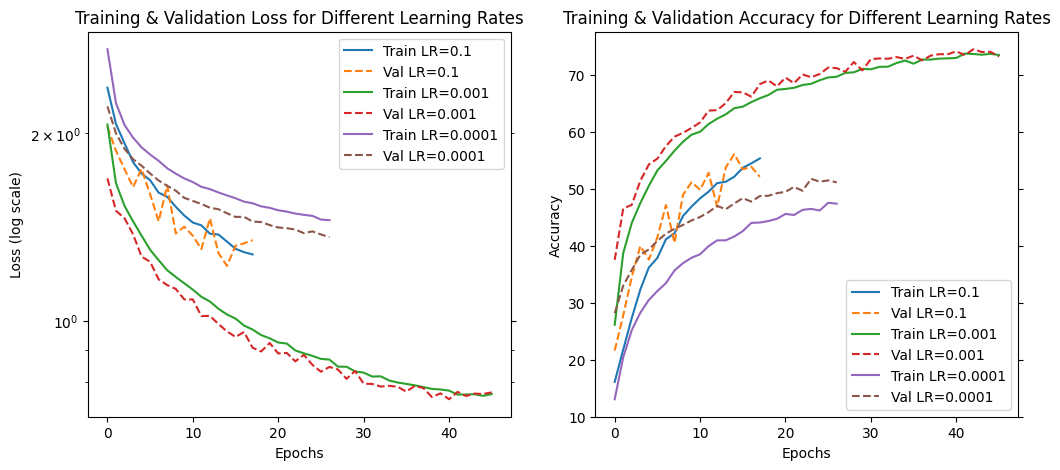

In [ ]:
# Optimized plot with logarithmic scale for loss[]
plt.figure(figsize=(12, 5))

# Plot Loss Comparison with log scale and explicit y-axis labels
plt.subplot(1, 2, 1)
for lr in learning_rates:
    plt.plot(results[lr][0], label=f"Train LR={lr}")
    plt.plot(results[lr][1], linestyle='dashed', label=f"Val LR={lr}")
plt.xlabel("Epochs")
plt.ylabel("Loss (log scale)")
plt.title("Training & Validation Loss for Different Learning Rates")
plt.yscale("log")  # Apply logarithmic scale for better visualization
plt.tick_params(axis='y', which='both', left=True, right=True, labelleft=True)
plt.legend()

# Plot Accuracy Comparison with y-axis labels
plt.subplot(1, 2, 2)
for lr in learning_rates:
    plt.plot(results[lr][2], label=f"Train LR={lr}")
    plt.plot(results[lr][3], linestyle='dashed', label=f"Val LR={lr}")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy for Different Learning Rates")
plt.tick_params(axis='y', which='both', left=True, right=True, labelleft=True)
plt.legend()

plt.show()


### 3 Model testing [10 marks]
Online evaluation of your model performance on the test set. 

> Prepare the dataloader for the testset.

> Write evaluation code for writing predictions.

> Upload it to Kaggle submission page (6 marks).


#### 3.1 Test class and predictions (4 marks)

> Build a test class, prepare a test dataloader and generate predictions.

Create a PyTorch ```Dataset``` for the unlabeled test data in the test_set folder of the Kaggle competition and generate predictions using your final model. Test data can be downloaded [here](https://www.kaggle.com/competitions/comp5623m-artificial-intelligence/data?select=test_set).

In [ ]:
import os
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from natsort import natsorted

# Config
dataset_dir = "./comp5625M_data_assessment_1"
test_data_path = os.path.join(dataset_dir, "test_set/test_set")
submission_filename = "sc21nl.csv"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Test data class
class TestTinyImageNetDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = natsorted([
            os.path.join(root_dir, img) for img in os.listdir(root_dir)
            if img.lower().endswith(('png', 'jpg', 'jpeg'))
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return image, os.path.basename(img_path)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            return None, None

# Transform
test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_dataset = TestTinyImageNetDataset(test_data_path, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

model = CNNModel(num_classes=30, dropout_prob=0.4)
try:
    model.load_state_dict(torch.load("cnn_model_best.pth", map_location=device))
    model.to(device)
    model.eval()
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()


Model loaded successfully!


#### 3.2 Prepare your submission and upload to Kaggle  (6 marks)

Save all test predictions to a CSV file and submit it to the private class Kaggle competition. **Please save your test CSV file submissions using your student username (the one with letters, e.g., ``sc15jb``, not the ID with only numbers)**, for example, `sc15jb.csv`. That will help us to identify your submissions.

The CSV file must contain only two columns: ‘Id’ and ‘Category’ (predicted class ID) as shown below:

```txt
Id,Category
28d0f5e9_373c.JPEG,2
bbe4895f_40bf.JPEG,18
```

The ‘Id’ column should include the name of the image. It is important to keep the same name as the one on the test set. Do not include any path, just the name of file (with extension). Your csv file must contain 1501 rows, one for each image in test set and 1 row for the headers. [To submit please click here.](https://www.kaggle.com/t/917fe52f6a3c4855880a24b34f26db07)

> You may submit multiple times. We will use your personal top entry for allocating marks for this [6 marks]. 


In [ ]:
# Prediction
predictions = []
image_ids = []

with torch.no_grad():
    for images, img_names in test_loader:
        if images is None:
            continue
        images = images.to(device)
        outputs = model(images)
        predicted_labels = torch.argmax(outputs, dim=1).cpu().numpy()

        for img_name, label in zip(img_names, predicted_labels):
            if img_name:
                image_ids.append(img_name)
                predictions.append(label)

# Save to CSV
submission_df = pd.DataFrame({"Id": image_ids, "Category": predictions})
submission_df.to_csv(submission_filename, index=False)
print(f"\n Predictions saved to {submission_filename}. Ready for Kaggle submission!")



 Predictions saved to sc21nl.csv. Ready for Kaggle submission!



### 4 Model Fine-tuning/transfer learning on CIFAR10 dataset  [16 marks]

Fine-tuning is a way of applying or utilizing transfer learning. It is a process that takes a model that has already been trained for one given task and then tunes or tweaks the model to make it perform a second similar task. You can perform fine-tuning in the following fashion:

- Train an entire model: Start training model from scratch (large dataset, more computation)

- Train some layers, freeze others: Lower layer features are general (problem independent) while higher layer features are specific (problem dependent – freeze)

- Freeze convolution base and train only last FC layers (small dataset and lower computation) 

> **Configuring your dataset**
   - Download your dataset using ``torchvision.datasets.CIFAR10`` [explained here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)
   - Split training dataset into training and validation set similar to above. *Note that the number of categories here is only 10*


> Load pretrained AlexNet from PyTorch - use model copies to apply transfer learning in different configurations

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for pretrained models
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split training dataset into training and validation sets
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


#### 4.1 Apply transfer learning with pretrained model weights (6 marks)


> Configuration 1: No frozen layers

In [ ]:
import json
# Load pre-trained AlexNet model
original_model = models.alexnet(pretrained=True)

# Create different model configurations
model_full_train = copy.deepcopy(original_model)  # Full model training

# Modify the final classification layer
num_ftrs = model_full_train.classifier[6].in_features
model_full_train.classifier[6] = nn.Linear(num_ftrs, 10)
model_full_train = model_full_train.to(device)

# Print trainable parameters
def print_trainable_parameters(model):
    print("Trainable parameters:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name, param.shape)

print_trainable_parameters(model_full_train)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_full_train.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    print("Starting training...")
    history = {'loss': [], 'accuracy': []}
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            if batch_idx % 10 == 0:  # Print every 10 batches
                print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(train_loader)} processed")
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_acc)
        
        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}', flush=True)
    
    # Save the trained model
    torch.save(model.state_dict(), "fine_tuned_model1.pth")
    print("Model saved as fine_tuned_model1.pth")
    
    # Save training history
    with open("training_history1.json", "w") as f:
        json.dump(history, f)
    print("Training history saved as training_history1.json")

# Train the model (Configuration 1: No frozen layers)
train_model(model_full_train, train_loader, criterion, optimizer, epochs=10)

/Users/natalieleung/miniforge3/envs/nat/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/natalieleung/miniforge3/envs/nat/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Trainable parameters:
features.0.weight torch.Size([64, 3, 11, 11])
features.0.bias torch.Size([64])
features.3.weight torch.Size([192, 64, 5, 5])
features.3.bias torch.Size([192])
features.6.weight torch.Size([384, 192, 3, 3])
features.6.bias torch.Size([384])
features.8.weight torch.Size([256, 384, 3, 3])
features.8.bias torch.Size([256])
features.10.weight torch.Size([256, 256, 3, 3])
features.10.bias torch.Size([256])
classifier.1.weight torch.Size([4096, 9216])
classifier.1.bias torch.Size([4096])
classifier.4.weight torch.Size([4096, 4096])
classifier.4.bias torch.Size([4096])
classifier.6.weight torch.Size([10, 4096])
classifier.6.bias torch.Size([10])
Starting training...
Epoch 1, Batch 0/1250 processed
Epoch 1, Batch 10/1250 processed
Epoch 1, Batch 20/1250 processed
Epoch 1, Batch 30/1250 processed
Epoch 1, Batch 40/1250 processed
Epoch 1, Batch 50/1250 processed
Epoch 1, Batch 60/1250 processed
Epoch 1, Batch 70/1250 processed
Epoch 1, Batch 80/1250 processed
Epoch 1, Batch 

#### 4.2 Fine-tuning model with frozen layers (6 marks)

> Configuration 2: Frozen base convolution blocks

In [ ]:
# Load pre-trained AlexNet model
original_model = models.alexnet(pretrained=True)

# Create different model configurations
model_frozen_base = copy.deepcopy(original_model)  # Frozen base convolution blocks

# Freeze convolutional base layers
for param in model_frozen_base.features.parameters():
    param.requires_grad = False

# Modify the final classification layer
num_ftrs = model_frozen_base.classifier[6].in_features
model_frozen_base.classifier[6] = nn.Linear(num_ftrs, 10)
model_frozen_base = model_frozen_base.to(device)

# Print trainable parameters
def print_trainable_parameters(model):
    print("Trainable parameters:")
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name, param.shape)

print_trainable_parameters(model_frozen_base)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_frozen_base.classifier.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    print("Starting training...")
    history = {'loss': [], 'accuracy': []}
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
            if batch_idx % 10 == 0:  # Print every 10 batches
                print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(train_loader)} processed")
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        history['loss'].append(epoch_loss)
        history['accuracy'].append(epoch_acc)
        
        print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}', flush=True)
    
    # Save the trained model
    torch.save(model.state_dict(), "fine_tuned_model2.pth")
    print("Model saved as fine_tuned_model2.pth")
    
    # Save training history
    with open("training_history2.json", "w") as f:
        json.dump(history, f)
    print("Training history saved as training_history2.json")

# Train the model (Configuration 2: Frozen base convolution blocks)
train_model(model_frozen_base, train_loader, criterion, optimizer, epochs=10)


Trainable parameters:
classifier.1.weight torch.Size([4096, 9216])
classifier.1.bias torch.Size([4096])
classifier.4.weight torch.Size([4096, 4096])
classifier.4.bias torch.Size([4096])
classifier.6.weight torch.Size([10, 4096])
classifier.6.bias torch.Size([10])
Starting training...
Epoch 1, Batch 0/1250 processed
Epoch 1, Batch 10/1250 processed
Epoch 1, Batch 20/1250 processed
Epoch 1, Batch 30/1250 processed
Epoch 1, Batch 40/1250 processed
Epoch 1, Batch 50/1250 processed
Epoch 1, Batch 60/1250 processed
Epoch 1, Batch 70/1250 processed
Epoch 1, Batch 80/1250 processed
Epoch 1, Batch 90/1250 processed
Epoch 1, Batch 100/1250 processed
Epoch 1, Batch 110/1250 processed
Epoch 1, Batch 120/1250 processed
Epoch 1, Batch 130/1250 processed
Epoch 1, Batch 140/1250 processed
Epoch 1, Batch 150/1250 processed
Epoch 1, Batch 160/1250 processed
Epoch 1, Batch 170/1250 processed
Epoch 1, Batch 180/1250 processed
Epoch 1, Batch 190/1250 processed
Epoch 1, Batch 200/1250 processed
Epoch 1, Bat

#### 4.3 Compare above configurations and comment on performances. (4 marks)

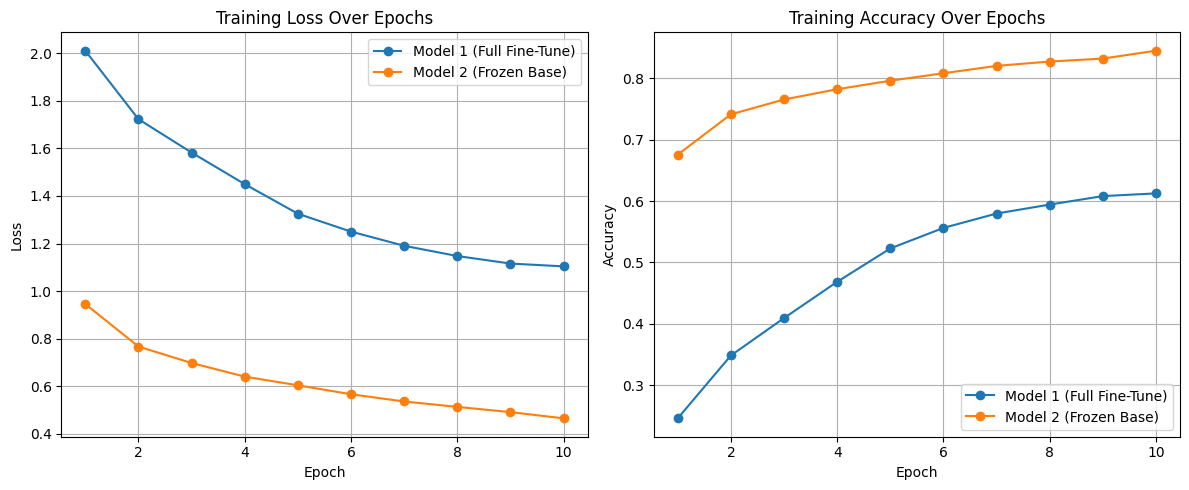

In [ ]:
import json
import matplotlib.pyplot as plt

# Load training history files
with open("training_history1.json", "r") as f:
    history1 = json.load(f)

with open("training_history2.json", "r") as f:
    history2 = json.load(f)

# Extract loss and accuracy
loss1 = history1["loss"]
acc1 = history1["accuracy"]
loss2 = history2["loss"]
acc2 = history2["accuracy"]

# Plotting
epochs = range(1, len(loss1) + 1)

plt.figure(figsize=(12, 5))

# Training Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss1, label="Model 1 (Full Fine-Tune)", marker='o')
plt.plot(epochs, loss2, label="Model 2 (Frozen Base)", marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

# Training Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc1, label="Model 1 (Full Fine-Tune)", marker='o')
plt.plot(epochs, acc2, label="Model 2 (Frozen Base)", marker='o')
plt.title("Training Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Part II: Multimodal data training [40 marks]


### Motivation 

Through this part of assessment you will:

> 1. Use a Recurrent Neural Network (RNN) to predict the caption of an image from established word vocabularies
> 2. Understand and visualise text predictions for a given image.
> 3. Learn to use transformers for image embedding and transformer-based large language models for text embedding learning. (new)

#### Dataset
This assessment will use a subset of the [COCO "Common Objects in Context" dataset](https://cocodataset.org/) for image caption generation. COCO contains 330K images, of 80 object categories, and at least five textual reference captions per image. Our subset consists of nearly 5070 of these images, each of which has five or more different descriptions of the salient entities and activities, and we will refer to it as COCO_5070.

To download the data:

> 1. **Images and annotations**: download the zipped file provided in the link here as [``COMP5625M_data_assessment_2.zip``](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/EWWzE-_AIrlOkvOKxH4rjIgBF_eUx8KDJMPKM2eHwCE0dg?e=DdX62H). 

``Info only:`` To understand more about the COCO dataset you can look at the [download page](https://cocodataset.org/#download). We have already provided you with the "2017 Train/Val annotations (241MB)" but our image subset consists of fewer images compared to orginial COCO dataset. So, no need to download anything from here! 

> 2. **Image meta data**: as our set is a subset of full COCO dataset, we have created a CSV file containing relevant meta data for our particular subset of images. You can download it also from Drive, "coco_subset_meta.csv" at the same link as 1.

#### Submission

You can either submit the same file or make two separate .ipython notebook files zipped in the submission (please name as ``yourstudentusername_partI.ipynb`` and ``yourstudentusername_partII.ipynb``). 

**Final note:**

> **Please include in this notebook everything that you would like to be marked, including figures. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.


The basic principle of our image-to-text model is as pictured in the diagram below, where an Encoder network encodes the input image as a feature vector by providing the outputs of the last fully-connected layer of a pre-trained CNN (we use [ResNet50](https://arxiv.org/abs/1512.03385)). This pretrained network has been trained on the complete ImageNet dataset and is thus able to recognise common objects. 

You can alternatively use the COCO trained pretrained weights from [PyTorch](https://pytorch.org/vision/stable/models.html). One way to do this is use the "FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1" but use e.g., "resnet_model = model.backbone.body". Alternatively, you can use the checkpoint from your previous coursework where you fine-tuned to COCO dataset. 

These features are then fed into a Decoder network along with the reference captions. As the image feature dimensions are large and sparse, the Decoder network includes a linear layer which downsizes them, followed by *a batch normalisation layer to speed up training*. Those resulting features, as well as the reference text captions, are then passed into a recurrent network (we will use an **RNNs** in this assessment). 

> Please note that we have already computed the encoder features  as ``coco_features.pt`` for you so you can use these directly in training and validation (dataset_train, dataset_valid) using ResNet50 encoder so please directly load the checkpoint.


### Sample RNN image captioning
The reference captions used to compute loss are represented as numerical vectors via an **embedding layer** whose weights are learned during training.

<!-- ![Encoder Decoder](comp5625M_figure.jpg) -->

<div>
<center><img src="comp5625M_figure_v3.jpg" width="1000"/></center>
</div>


### Instructions for creating vocabulary 

A helper function file ``helperDL.py`` is provided that includes all the functions that will do the following for you. You can easily import these functions in the exercise, most are already done for you!  

> 1. Extracting image features (a pre-trained checkpoint is provided ``coco_features_{cpu/gpu}.pt`` for you to download and use it for training your RNN)
> 2. Text preparation of training and validation data is provided

In [173]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np

In [174]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [175]:
# Load the feature map provided to you -> "coco_features.pt"
features_map = torch.load('coco_features.pt', map_location=device)

#### 5 Train an RNN-based image captioning [20 marks]

Most of the background codes are provided to you. You only will require to write down the code based on your understanding to:

> 5.1 Design a RNN-based decoder. (8 marks)

> 5.2 Train your model with precomputed features. (6 Marks)

> 5.3 Train using new parameters. (6 Marks)




#### Text data preparation

In [176]:
import pandas as pd
# captions.csv is provided to you
# coco/images/ folder is provided to you

captions_path = './'
image_path  = "coco/images/"
df = pd.read_csv(captions_path+"captions.csv")

#visualise
df.head(10)

image_id      id                                            caption  \
0         9  661611  Closeup of bins of food that include broccoli ...   
1         9  661977  A meal is presented in brightly colored plasti...   
2         9  663627  there are containers filled with different kin...   
3         9  666765  Colorful dishes holding meat, vegetables, frui...   
4         9  667602         A bunch of trays that have different food.   
5        25  127238      A giraffe mother with its baby in the forest.   
6        25  127076               A giraffe standing up nearby a tree    
7        25  133058       Two giraffes standing in a tree filled area.   
8        25  133676  A giraffe standing next to a forest filled wit...   
9        25  122312    A giraffe eating food from the top of the tree.   

              image  
0  000000000009.jpg  
1  000000000009.jpg  
2  000000000009.jpg  
3  000000000009.jpg  
4  000000000009.jpg  
5  000000000025.jpg  
6  000000000025.jpg  
7  000000000025.jpg  
8  000000000025.jpg  
9  000000000025.jpg

In [177]:
# Note: For RNN you will need to clean the text, for e.g., converting all uppercases to lowercases 
# gen_clean_captions_df fuction will do this for you.

df["clean_caption"] = ""
from helperDL import gen_clean_captions_df
df_clean = gen_clean_captions_df(df)
df_clean.head(10)

image_id      id                                            caption  \
0         9  661611  Closeup of bins of food that include broccoli ...   
1         9  661977  A meal is presented in brightly colored plasti...   
2         9  663627  there are containers filled with different kin...   
3         9  666765  Colorful dishes holding meat, vegetables, frui...   
4         9  667602         A bunch of trays that have different food.   
5        25  127238      A giraffe mother with its baby in the forest.   
6        25  127076               A giraffe standing up nearby a tree    
7        25  133058       Two giraffes standing in a tree filled area.   
8        25  133676  A giraffe standing next to a forest filled wit...   
9        25  122312    A giraffe eating food from the top of the tree.   

              image                                      clean_caption  
0  000000000009.jpg  closeup of bins of food that include broccoli ...  
1  000000000009.jpg  a meal is presented in brightly colored plasti...  
2  000000000009.jpg  there are containers filled with different kin...  
3  000000000009.jpg  colorful dishes holding meat vegetables fruit ...  
4  000000000009.jpg          a bunch of trays that have different food  
5  000000000025.jpg       a giraffe mother with its baby in the forest  
6  000000000025.jpg                a giraffe standing up nearby a tree  
7  000000000025.jpg        two giraffes standing in a tree filled area  
8  000000000025.jpg  a giraffe standing next to a forest filled wit...  
9  000000000025.jpg     a giraffe eating food from the top of the tree

In [178]:
# Note: For RNN you will need to clean the text, for e.g., converting all uppercases to lowercases 
# gen_clean_captions_df fuction will do this for you.

df["clean_caption"] = ""
from helperDL import gen_clean_captions_df
df_clean = gen_clean_captions_df(df)
df_clean.head(10)

image_id      id                                            caption  \
0         9  661611  Closeup of bins of food that include broccoli ...   
1         9  661977  A meal is presented in brightly colored plasti...   
2         9  663627  there are containers filled with different kin...   
3         9  666765  Colorful dishes holding meat, vegetables, frui...   
4         9  667602         A bunch of trays that have different food.   
5        25  127238      A giraffe mother with its baby in the forest.   
6        25  127076               A giraffe standing up nearby a tree    
7        25  133058       Two giraffes standing in a tree filled area.   
8        25  133676  A giraffe standing next to a forest filled wit...   
9        25  122312    A giraffe eating food from the top of the tree.   

              image                                      clean_caption  
0  000000000009.jpg  closeup of bins of food that include broccoli ...  
1  000000000009.jpg  a meal is presented in brightly colored plasti...  
2  000000000009.jpg  there are containers filled with different kin...  
3  000000000009.jpg  colorful dishes holding meat vegetables fruit ...  
4  000000000009.jpg          a bunch of trays that have different food  
5  000000000025.jpg       a giraffe mother with its baby in the forest  
6  000000000025.jpg                a giraffe standing up nearby a tree  
7  000000000025.jpg        two giraffes standing in a tree filled area  
8  000000000025.jpg  a giraffe standing next to a forest filled wit...  
9  000000000025.jpg     a giraffe eating food from the top of the tree

In [179]:
##### Spilt your training, validation and test dataset with indexes to each set
from helperDL import split_ids
train_id, valid_id, test_id = split_ids(df['id'].unique())
print("training:{}, validation:{}, test:{}".format(len(train_id), len(valid_id), len(test_id)))

training:17744, validation:2534, test:5071


In [180]:
train_set = df.loc[df['id'].isin(train_id)]
valid_set = df.loc[df['id'].isin(valid_id)]
test_set = df.loc[df['id'].isin(test_id)]

In [181]:
#### word 2 an integer ID - build vocabulary
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [182]:
### build vocabulariy for each set - train, val and test 
# you will be using to create dataloaders
from helperDL import build_vocab

# create a vocab instance
vocab = Vocabulary()
vocab_train = build_vocab(train_id, df_clean, vocab)
vocab_valid = build_vocab(valid_id, df_clean, vocab)
vocab_test = build_vocab(test_id, df_clean, vocab)

vocab = vocab_train # using only training samples as vocabulary as instructed above
print("Total vocabulary size: {}".format(len(vocab_train)))


Total vocabulary size: 2314


In [183]:
# They can also join the train and valid captions but they will need to run vocabulary after concatenation
import numpy as np
vocab = build_vocab(np.concatenate((train_id, valid_id), axis=0), df_clean, vocab) #---> overrighting
len(vocab)

2488

Instantiate a ```DataLoader``` for your image feature and caption dataset. ``helperDL.py`` file includes all the required functions

We need to overwrite the default PyTorch collate_fn() because our 
ground truth captions are sequential data of varying lengths. The default
collate_fn() does not support merging the captions with padding.

You can read more about it here:
https://pytorch.org/docs/stable/data.html#dataloader-collate-fn. 


In [184]:
from helperDL import EncoderCNN  
model = EncoderCNN() 
print(model)

/Users/natalieleung/miniforge3/envs/nat/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/natalieleung/miniforge3/envs/nat/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EncoderCNN(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64

In [185]:
''' Load the saved image feature maps and trained model ("provided to you") '''

# ---> your entry here (make sure that the path is correct - load the coco_features_{cpu/gpu}.pt)
features_map = torch.load("coco_features.pt", map_location=device)



In [186]:
##### Preparing the train, val and test dataloaders
from helperDL import COCO_Features
from helperDL import caption_collate_fn

# Create a dataloader for train
dataset_train = COCO_Features(
    df=train_set,
    vocab=vocab,
    features=features_map,
)

train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=32,
    shuffle=True,
    num_workers=0, # may need to set to 0
    collate_fn=caption_collate_fn, # explicitly overwrite the collate_fn
)

# Create a dataloader for valid
dataset_valid = COCO_Features(
    df=valid_set,
    vocab=vocab,
    features=features_map,
)

valid_loader = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=32,
    shuffle=True,
    num_workers=0, # may need to set to 0
    collate_fn=caption_collate_fn, # explicitly overwrite the collate_fn
)

In [187]:
# Configuration file - You will be asked below to train your RNN using various configurations and compare.
# --> Please change these numbers as required. 
# --> Please comment on changes that you do.

class cfg:
    EMBED_SIZE = 256
    HIDDEN_SIZE = 512
    NUM_LAYERS = 1
    LR = 0.001
    NUM_EPOCHS = 5
    LOG_STEP = 10
    MAX_SEQ_LEN = 37

#### 5.1 Design a RNN-based decoder (8 marks)

Read through the ```DecoderRNN``` model below. First, complete the decoder by adding an ```RNN``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```, which you may set to True.

In particular, understand the meaning of ```pack_padded_sequence()``` as used in ```forward()```. Refer to the [PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).

In [188]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=cfg.EMBED_SIZE, hidden_size=cfg.HIDDEN_SIZE, num_layers=cfg.NUM_LAYERS, max_seq_length=cfg.MAX_SEQ_LEN):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        # we want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last fc layer (dimensions 1 x 2048)
        # into a Linear layer to resize
        self.resize = nn.Linear(2048, embed_size)
        
        # batch normalisation helps to speed up training
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

        # Embedding layer
        self.embed = nn.Embedding(vocab_size, embed_size)

        # ---> RNN (use nn.RNN function passing arguments that you computed above, use batch_first=True as an argument)
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True)


        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""

        # a) compute the embedding of caption (Complete the code!)
        embeddings = self.embed(captions)
        # b) resize the image features (Complete the code!)
        im_features = self.resize(features)
        # c) apply batch norm on image the resized feature (Complete the code!)
        im_features = self.bn(im_features)
        # d) concatenate the image feature and the embeddings - use unsqueeze(1) to make the appropriate  size
        embeddings = torch.cat((im_features.unsqueeze(1), embeddings), 1)
        # e) use pack_padded_sequence 
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.rnn(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    

    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []

        inputs = self.bn(self.resize(features)).unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)  # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))   # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)               # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)              # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)       # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

In [189]:
# instantiate decoder
decoder = DecoderRNN(len(vocab), embed_size=cfg.EMBED_SIZE, hidden_size=cfg.HIDDEN_SIZE, num_layers=cfg.NUM_LAYERS).to(device)

##### 5.2 Train your model with precomputed features [6 marks]

Train the decoder by passing the features, reference captions, and targets to the decoder, then computing loss based on the outputs and the targets. Note that when passing the targets and model outputs to the loss function, the targets will also need to be formatted using ```pack_padded_sequence()```.

We recommend a batch size of around 64 (though feel free to adjust as necessary for your hardware).

**We strongly recommend saving a checkpoint of your trained model after training so you don't need to re-train multiple times.**

Display a graph of training and validation loss over epochs to justify your stopping point.

In [56]:
# Define: loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(decoder.parameters(), lr=cfg.LR)

In [57]:
def train():
    # train the models
    total_step = len(train_loader)
    total_step_v = len(valid_loader)
    stats = np.zeros((cfg.NUM_EPOCHS,2))
    print(stats.shape)
    total_loss = 0
    for epoch in range(cfg.NUM_EPOCHS):
        for i, (features_, captions_, lengths_) in enumerate(train_loader):

            # set mini-batch dataset
            features_ = features_.to(device)
            captions_ = captions_.to(device)
            targets = pack_padded_sequence(captions_, lengths_, batch_first=True)[0]
            decoder.zero_grad()

            # forward, backward and optimize
            outputs = decoder(features_, captions_, lengths_)
            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

            # print stats
            if i % cfg.LOG_STEP == 0:
                print(f"Epoch [{epoch+1}/{cfg.NUM_EPOCHS}], Step [{i}/{total_step}], Loss: {loss.item():.4f}")
        
        stats[epoch,0] = round(total_loss/total_step,3)
        total_loss = 0
        decoder.eval()
        with torch.no_grad():  
            for i, (features_, captions_, lengths_) in enumerate(valid_loader):

                # set mini-batch dataset
                features_ = features_.to(device)
                captions_ = captions_.to(device)
                targets = pack_padded_sequence(captions_, lengths_, batch_first=True)[0]

                # forward, backward and optimize
                outputs = decoder(features_, captions_, lengths_)

                loss = criterion(outputs, targets)

                total_loss += loss.item()
        
        stats[epoch,1] = round(total_loss/total_step_v,3)
        total_loss = 0
        # print stats
        print("="*30)
        print(f"Epoch [{epoch+1}/{cfg.NUM_EPOCHS}], Train_Loss: {stats[epoch,0]}, Valid_Loss: {stats[epoch,1]}")
        print("="*30)
        decoder.train()

    return stats

In [168]:
def plot_stats(stats, figure_name="coco_train_vocab_only.png"):
    fig = plt.figure()
    plt.plot(stats[:,0], 'r', label = 'training', )
    plt.plot(stats[:,1], 'g', label = 'validation' )
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(f"COCO dataset- train vocab only #vocab={len(vocab)}")
    fig.savefig(figure_name)
    plt.show()

#### Train using default parameters

(5, 2)
Epoch [1/5], Step [0/555], Loss: 7.8712
Epoch [1/5], Step [10/555], Loss: 5.7630
Epoch [1/5], Step [20/555], Loss: 5.4379
Epoch [1/5], Step [30/555], Loss: 5.2789
Epoch [1/5], Step [40/555], Loss: 5.2493
Epoch [1/5], Step [50/555], Loss: 4.8639
Epoch [1/5], Step [60/555], Loss: 4.6805
Epoch [1/5], Step [70/555], Loss: 4.7417
Epoch [1/5], Step [80/555], Loss: 4.5505
Epoch [1/5], Step [90/555], Loss: 4.5424
Epoch [1/5], Step [100/555], Loss: 4.1578
Epoch [1/5], Step [110/555], Loss: 4.2427
Epoch [1/5], Step [120/555], Loss: 4.1951
Epoch [1/5], Step [130/555], Loss: 4.3341
Epoch [1/5], Step [140/555], Loss: 4.1374
Epoch [1/5], Step [150/555], Loss: 4.2245
Epoch [1/5], Step [160/555], Loss: 4.0185
Epoch [1/5], Step [170/555], Loss: 3.8086
Epoch [1/5], Step [180/555], Loss: 4.0610
Epoch [1/5], Step [190/555], Loss: 4.0692
Epoch [1/5], Step [200/555], Loss: 3.5549
Epoch [1/5], Step [210/555], Loss: 3.7174
Epoch [1/5], Step [220/555], Loss: 3.9062
Epoch [1/5], Step [230/555], Loss: 3.6

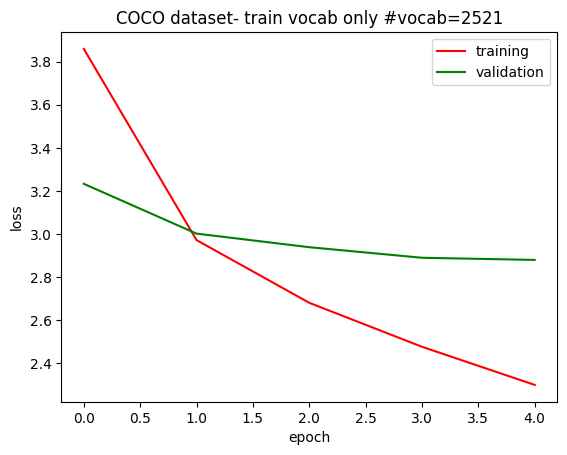

In [59]:
stats = train()
plot_stats(stats, "coco_default_parameters.png")

#### 5.3 Train using new parameters (6 Marks)

> In CFG class change --> NUM_LAYERS = 2 and  EMBED_SIZE = 512


In [190]:
# Configuration file - You will be asked below to train your RNN using various configurations and compare.
# --> Please change these numbers as required. 
# --> Please comment on changes that you do.

class cfg:
    EMBED_SIZE = 512
    HIDDEN_SIZE = 512
    NUM_LAYERS = 2
    LR = 0.0005 # changed
    NUM_EPOCHS = 10 #changed from 5 to 10
    LOG_STEP = 10
    MAX_SEQ_LEN = 37


(10, 2)
Epoch [1/10], Step [0/555], Loss: 7.8329
Epoch [1/10], Step [10/555], Loss: 5.8732
Epoch [1/10], Step [20/555], Loss: 5.2223
Epoch [1/10], Step [30/555], Loss: 5.2960
Epoch [1/10], Step [40/555], Loss: 5.0490
Epoch [1/10], Step [50/555], Loss: 4.9355
Epoch [1/10], Step [60/555], Loss: 4.7216
Epoch [1/10], Step [70/555], Loss: 4.6272
Epoch [1/10], Step [80/555], Loss: 4.2276
Epoch [1/10], Step [90/555], Loss: 4.0296
Epoch [1/10], Step [100/555], Loss: 4.4731
Epoch [1/10], Step [110/555], Loss: 4.2987
Epoch [1/10], Step [120/555], Loss: 4.2097
Epoch [1/10], Step [130/555], Loss: 3.8973
Epoch [1/10], Step [140/555], Loss: 3.9851
Epoch [1/10], Step [150/555], Loss: 4.0862
Epoch [1/10], Step [160/555], Loss: 3.7622
Epoch [1/10], Step [170/555], Loss: 3.8211
Epoch [1/10], Step [180/555], Loss: 4.1507
Epoch [1/10], Step [190/555], Loss: 4.0150
Epoch [1/10], Step [200/555], Loss: 3.6288
Epoch [1/10], Step [210/555], Loss: 3.5651
Epoch [1/10], Step [220/555], Loss: 3.7184
Epoch [1/10], 

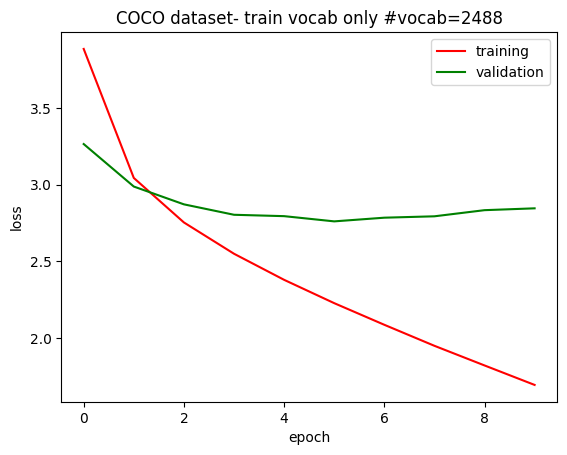

In [191]:
# save the best model after training
#your code here! e.g.: decoder_ckpt = torch.save(decoder, "coco_subset_assessment_decoder.ckpt")
# Re-instantiate decoder with new parameters
decoder = DecoderRNN(len(vocab), embed_size=cfg.EMBED_SIZE, hidden_size=cfg.HIDDEN_SIZE, num_layers=cfg.NUM_LAYERS).to(device)

# Redefine optimizer (because model parameters changed)
optimizer = torch.optim.Adam(decoder.parameters(), lr=cfg.LR)
stats_new = train()
plot_stats(stats_new, "coco_new_parameters.png")
torch.save({
    'model_state_dict': decoder.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'vocab_size': len(vocab),
    'embed_size': cfg.EMBED_SIZE,
    'hidden_size': cfg.HIDDEN_SIZE,
    'num_layers': cfg.NUM_LAYERS
}, "decoder_new.ckpt")



### 6 Test prediction and evaluation [8 marks] 

#### 6.1 Generate predictions on test data (4 marks)

Display 4 sample test images containing different objects, along with your model’s generated captions and all the reference captions for each.

> Remember that everything **displayed** in the submitted notebook and .html file will be marked, so be sure to run all relevant cells.

In [95]:
from helperDL import COCOImagesDataset

data_transform = transforms.Compose([ 
    transforms.Resize(224),     
    transforms.CenterCrop(224), 
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

dataset_test = COCOImagesDataset(
    df=test_set,
    transform=data_transform,
)
test_loader = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=32,
    shuffle=False,
    num_workers=0)

In [ ]:
model.eval()
decoder.eval() # generate caption, eval mode to not influence batchnormncoder.eval()

DecoderRNN(
  (resize): Linear(in_features=2048, out_features=512, bias=True)
  (bn): BatchNorm1d(512, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (embed): Embedding(2521, 512)
  (rnn): RNN(512, 512, num_layers=2, batch_first=True)
  (linear): Linear(in_features=512, out_features=2521, bias=True)
)

GENERATED: a vase filled with yellow and purple flowers

REFERENCES:
- white vase with different colored flowers sitting inside of it
- a flower vase is sitting on a porch stand
- a white vase with many flowers on a stage
- a vase with red and white flowers outside on a sunny day
- a white vase filled with different colored flowers


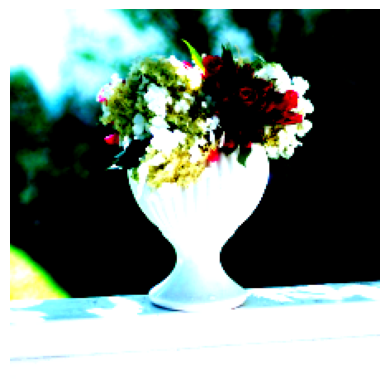

GENERATED: a small dog laying on a bed with a cat

REFERENCES:
- a small dog is curled up on top of the shoes
- a shoe rack with some shoes and a dog sleeping on them
- this wire metal rack holds several pairs of shoes and sandals
- various slides and other footwear rest in a metal basket outdoors
- a dog sleeping on a show rack in the shoes


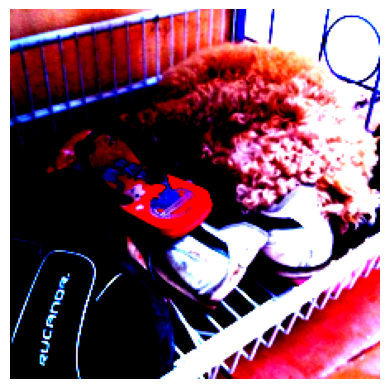

GENERATED: two costumed horses in a field with people walking around

REFERENCES:
- a couple of men riding horses on top of a green field
- a pair of horses performing tricks in a field
- two men are on horses that are reared back
- two costumed horse riders make their horses stand on their hind legs
- two horses and their riders on some grass


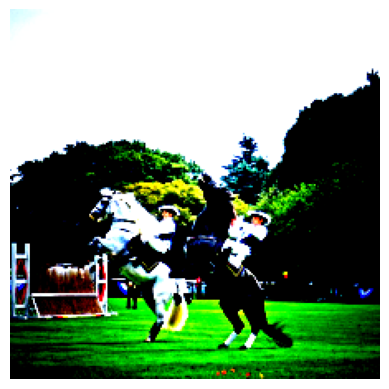

GENERATED: people on elephants are walking down a street

REFERENCES:
- some people in the woods riding two elephants
- several elephants in the jungle carrying people on their backs
- some people who are riding on top of elephants
- they are brave for riding in the jungle on those elephants
- there are people riding elephants in the middle of a forest


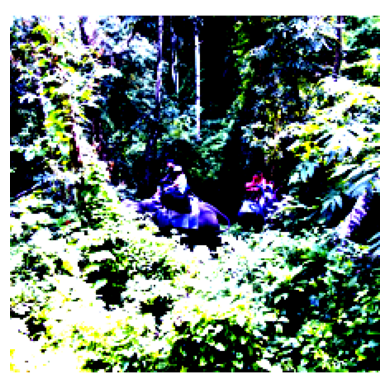

In [96]:
from torchvision.transforms.functional import to_pil_image

# Set number of images to display
IMAGES_TO_SHOW = 4
idx = 0

decoder.eval()
model.eval()

with torch.no_grad():
    for i, (images, filenames) in enumerate(test_loader):

        # Move images to device
        images = images.to(device)

        # Extract features using the encoder
        features = model(images)

        # Generate predicted captions
        sampled_ids = decoder.sample(features)

        # Convert word IDs to words
        sampled_ids = sampled_ids.cpu().numpy()

        for j in range(images.size(0)):

            # Decode the caption
            sampled_caption = []
            for word_id in sampled_ids[j]:
                word = vocab.idx2word[word_id]
                if word == '<end>':
                    break
                if word != '<pad>':
                    sampled_caption.append(word)
            sentence = ' '.join(sampled_caption)

            # Print the generated caption
            print(f"GENERATED: {sentence}\n")

            # Print the reference captions
            image_name = filenames[j]
            refs = df_clean[df_clean['image'] == image_name]['clean_caption'].tolist()

            print("REFERENCES:")
            for ref in refs:
                print(f"- {ref}")

            print("="*40)

            # Display the image
            img = to_pil_image(images[j].cpu().clamp(0, 1))  # de-normalize slightly for viewing
            plt.imshow(img)
            plt.axis('off')
            plt.show()

            idx += 1
            if idx == IMAGES_TO_SHOW:
                break
        if idx == IMAGES_TO_SHOW:
            break


#### 6.2 Caption evaluation using cosine similarity (4 marks)

The cosine similarity measures the cosine of the angle between two vectors in n-dimensional space. The smaller the angle, the greater the similarity.

To use the cosine similarity to measure the similarity between the generated caption and the reference captions: 

* Find the embedding vector of each word in the caption 
* Compute the average vector for each caption 
* Compute the cosine similarity score between the average vector of the generated caption and average vector of each reference caption
* Compute the average of these scores 

Calculate the cosine similarity using the model's predictions over the whole test set. 

In [ ]:
import torch.nn.functional as F
from datetime import datetime

def get_caption_embedding(caption_tokens, embed_layer):
    """Get the average embedding of a list of tokens"""
    embeddings = []
    for token in caption_tokens:
        if token in vocab.word2idx:
            idx = vocab(token)
            idx_tensor = torch.tensor(idx).to(device)
            emb = embed_layer(idx_tensor)
            embeddings.append(emb)
    if embeddings:
        embeddings = torch.stack(embeddings)
        avg_embedding = embeddings.mean(dim=0)
        return avg_embedding
    else:
        return torch.zeros(cfg.EMBED_SIZE).to(device)  # fallback if no known words

decoder.eval()
model.eval()

similarities = []

with torch.no_grad():
    for i, (images, filenames) in enumerate(test_loader):

        images = images.to(device)
        features = model(images)
        sampled_ids = decoder.sample(features)
        sampled_ids = sampled_ids.cpu().numpy()

        for j in range(images.size(0)):

            # Decode generated caption
            sampled_caption = []
            for word_id in sampled_ids[j]:
                word = vocab.idx2word[word_id]
                if word == '<end>':
                    break
                if word != '<pad>':
                    sampled_caption.append(word)

            if not sampled_caption:
                continue  # Skip empty generated captions

            generated_emb = get_caption_embedding(sampled_caption, decoder.embed)

            image_name = filenames[j]
            refs = df_clean[df_clean['image'] == image_name]['clean_caption'].tolist()

            ref_sims = []
            for ref in refs:
                ref_tokens = ref.split()
                if not ref_tokens:
                    continue
                ref_emb = get_caption_embedding(ref_tokens, decoder.embed)
                if torch.norm(ref_emb) == 0:
                    continue
                cos_sim = F.cosine_similarity(generated_emb.unsqueeze(0), ref_emb.unsqueeze(0)).item()
                ref_sims.append(cos_sim)

            if ref_sims:
                avg_sim = sum(ref_sims) / len(ref_sims)
                similarities.append(avg_sim)


# Final average similarity
if len(similarities) > 0:
    mean_cosine_similarity = sum(similarities) / len(similarities)
    current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{current_time}] Average Cosine Similarity on Test Set: {mean_cosine_similarity:.4f}")
else:
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] No valid similarities computed.")


[2025-04-30 00:49:02] Average Cosine Similarity on Test Set: 0.4511


## 7 Use language models for image captioning [12 marks]

Description: A large language model (LLM) is a type of artificial intelligence (AI) model that uses deep learning to perform natural language processing (NLP) tasks.

One way to train on multimodal (image and text data) is CLIP (Contrastive Language-Image Pre-Training). CLIP is a neural network trained on a variety of (image, text) pairs and can take CNNs or transformers for encoding images and widely accepted LLMs for text embedding. Paper here: https://arxiv.org/pdf/2103.00020

CLIP is trained on flickr 30K dataset. First we will try on flickr 8k data then on COCO.

> Most codes are provided for you. 
> Small model and large pre-trained models are given to you and also we have provided the configS and configL that are required to run these models.

[Download model checkpoints here](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/Eb6flxGirw5ErPUDAPzHB_wB109fykIhdOayeQIuDu_5Nw?e=bLGd6a)

[Download Flickr 8K dataset](https://leeds365-my.sharepoint.com/:u:/g/personal/scssali_leeds_ac_uk/ERcKkLeO2Q9LrVYn1L5ZUk4B9cPoKL95dwXU8zgtI1m8rg?e=K3kehC)


> **Your task is to:**

    - a. Understand how the smaller model perform on the flickr 8k and COCO dataset (2 images each) [4 marks]

    - b. Understand how the larger model perform on the flickr 8k and COCO dataset (2 images each) [4 marks]
    
    - c. Finally, understand how the CLIP model trained on a larger curated COCO dataset generalises to the COCO dataset (use same 2 images from above) [4 marks]

In [120]:
import os

#configuration for the smaller model (slightly over 1 GB model weight file)

class configS:
    """
    Project's main config.
    """

    clip_model: str = "openai/clip-vit-base-patch32"
    text_model: str = "gpt2"
    seed: int = 100
    num_workers: int = 2
    train_size: int = 0.84
    val_size: int = 0.13
    epochs: int = 150
    lr: int = 3e-3
    k: float = 0.33
    batch_size_exp: int = 6
    ep_len: int = 4
    num_layers: int = 6
    n_heads: int = 16
    forward_expansion: int = 4
    max_len: int = 40
    dropout: float = 0.1
    weights_dir: str = os.path.join("weights", "small")

In [123]:
#configuration for the larger model (nearly 3 GB model weight file)
class configL:
    """
    Project's main config - large.
    """

    clip_model: str = "openai/clip-vit-large-patch14"
    text_model: str = "gpt2-medium"
    seed: int = 100
    num_workers: int = 2
    train_size: int = 0.84
    val_size: int = 0.13
    epochs: int = 120
    lr: int = 5e-3
    k: float = 0.3
    batch_size_exp: int = 5
    ep_len: int = 4
    num_layers: int = 5
    n_heads: int = 16
    forward_expansion: int = 4
    max_len: int = 40
    dropout: float = 0.08
    weights_dir: str = os.path.join("weights", "large")

In [121]:
from model_CLIP import Net # function is given to you

model = Net(
    clip_model=configS.clip_model,
    text_model=configS.text_model,
    ep_len=configS.ep_len,
    num_layers=configS.num_layers,
    n_heads=configS.n_heads,
    forward_expansion=configS.forward_expansion,
    dropout=configS.dropout,
    max_len=configS.max_len,
    device=device,
)

#use small model
checkpoint = torch.load('CLIP_ckpts/model_S.pt', map_location=device) 
model.load_state_dict(checkpoint, strict=False)
# model.load_state_dict(checkpoint, strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['ie.model.embeddings.position_ids', 'td.model.transformer.h.0.attn.bias', 'td.model.transformer.h.0.attn.masked_bias', 'td.model.transformer.h.1.attn.bias', 'td.model.transformer.h.1.attn.masked_bias', 'td.model.transformer.h.2.attn.bias', 'td.model.transformer.h.2.attn.masked_bias', 'td.model.transformer.h.3.attn.bias', 'td.model.transformer.h.3.attn.masked_bias', 'td.model.transformer.h.4.attn.bias', 'td.model.transformer.h.4.attn.masked_bias', 'td.model.transformer.h.5.attn.bias', 'td.model.transformer.h.5.attn.masked_bias', 'td.model.transformer.h.6.attn.bias', 'td.model.transformer.h.6.attn.masked_bias', 'td.model.transformer.h.7.attn.bias', 'td.model.transformer.h.7.attn.masked_bias', 'td.model.transformer.h.8.attn.bias', 'td.model.transformer.h.8.attn.masked_bias', 'td.model.transformer.h.9.attn.bias', 'td.model.transformer.h.9.attn.masked_bias', 'td.model.transformer.h.10.attn.bias', 'td.model.transformer.h.10.attn.masked_bias

> Try on COCO dataset with the small model only - Comment on your observation.

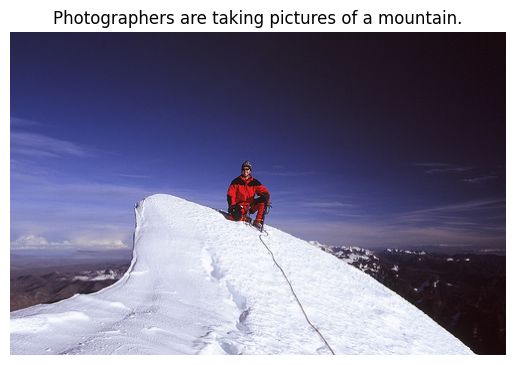

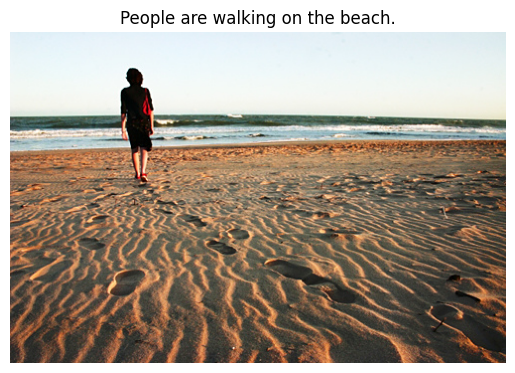

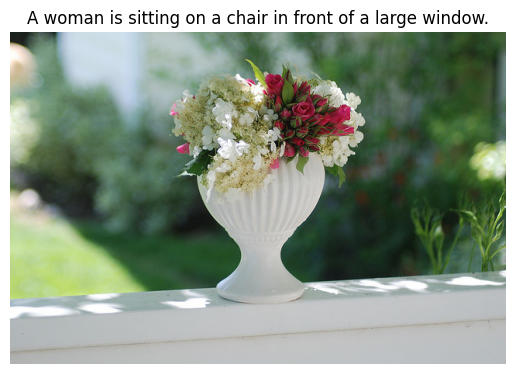

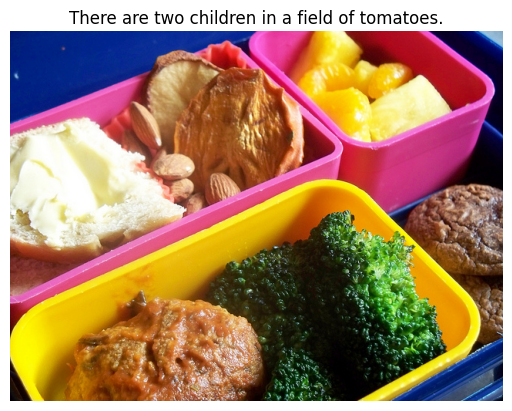

In [122]:
model.eval()
from PIL import Image
temperature = 1.0

# Output on two images of your choice from 'flickr 8k' 
img1 = Image.open('Flickr8k/Images/55473406_1d2271c1f2.jpg')
img2 = Image.open('Flickr8k/Images/260828892_7925d27865.jpg')
# Your code here:
for img in [img1, img2]:
    with torch.no_grad():
        caption, _ = model(img, temperature)
    plt.imshow(img)
    plt.title(caption)
    plt.axis("off")
    plt.show()

# Output on two images of your choice from 'COCO' dataset
img3 = Image.open(image_path + './000000000030.jpg')
img4 = Image.open(image_path + './000000000009.jpg')
# Your code here:
for img in [img3, img4]:
    with torch.no_grad():
        caption, _ = model(img, temperature)
    plt.imshow(img)
    plt.title(caption)
    plt.axis("off")
    plt.show()


The small model has a good performance on the Flickr8k dataset, producing captions such as Photographers are taking pictures of a mountain and People are walking on the beach, which are similar to the image content. However, its performance drops when applied to the COCO dataset. For example, it captions a lunchbox meal as There are two children in a field of tomatoes, and describes a vase of flowers as A woman is sitting on a chair in front of a large window. The results suggest that the small model struggles to generalise to COCO’s more complex and varied visual content, likely due to its limited model capacity and possibly less diverse training exposure.

> Repeat the above with the larger model "model_L" - use large model configuration. Comment on your observations.

In [124]:
model = Net(
    clip_model=configL.clip_model,
    text_model=configL.text_model,
    ep_len=configL.ep_len,
    num_layers=configL.num_layers,
    n_heads=configL.n_heads,
    forward_expansion=configL.forward_expansion,
    dropout=configL.dropout,
    max_len=configL.max_len,
    device=device,
)
checkpoint = torch.load('CLIP_ckpts/model_L.pt', map_location=device)

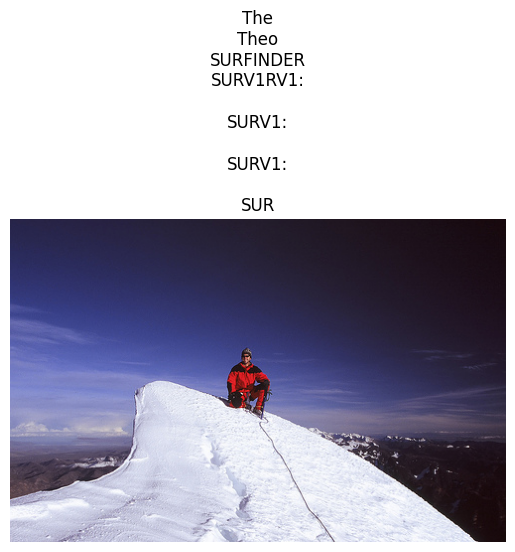

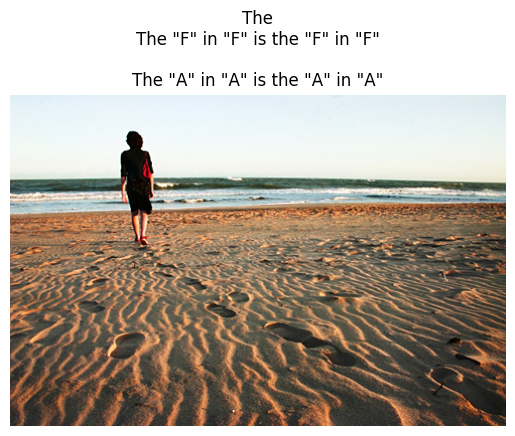

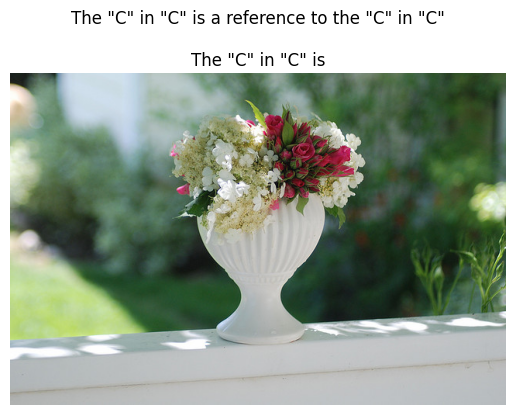

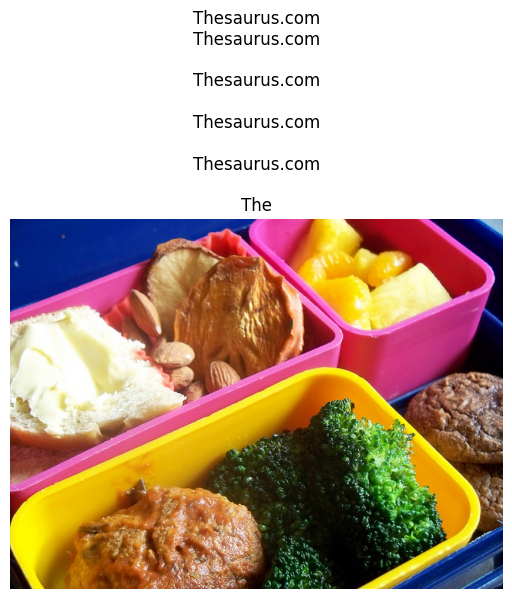

In [125]:
model.eval()
from PIL import Image
temperature = 1.0

# Output on two images of your choice from 'flickr 8k' 
img1 = Image.open('Flickr8k/Images/55473406_1d2271c1f2.jpg')
img2 = Image.open('Flickr8k/Images/260828892_7925d27865.jpg')
# Your code here:
for img in [img1, img2]:
    with torch.no_grad():
        caption, _ = model(img, temperature)
    plt.imshow(img)
    plt.title(caption)
    plt.axis("off")
    plt.show()

# Output on two images of your choice from 'COCO' dataset
img3 = Image.open(image_path + './000000000030.jpg')
img4 = Image.open(image_path + './000000000009.jpg')
# Your code here:
for img in [img3, img4]:
    with torch.no_grad():
        caption, _ = model(img, temperature)
    plt.imshow(img)
    plt.title(caption)
    plt.axis("off")
    plt.show()


The large model unexpectedly performs worse than the small model on both datasets. Although it has a larger capacity and was expected to generate more accurate captions, the outputs are incoherent and unrelated to the image content. It prints out repetitive phrases like "The Theo SURFINDER SURV1RV1: SURV1: SURV1: SUR". There may be a potential issue such as overfitting, poor alignment between the image and language features or an unstable decoder.

> Try on COCO dataset with the large model only - Comment on your observation. What would you have to do to improve network performance?

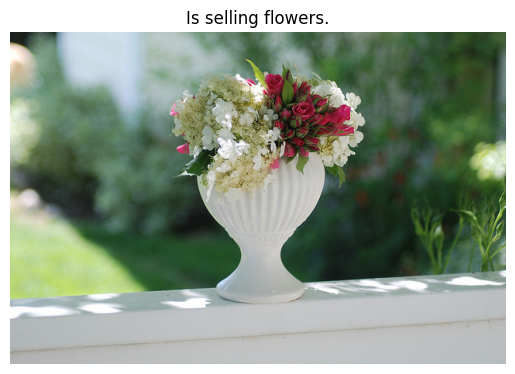

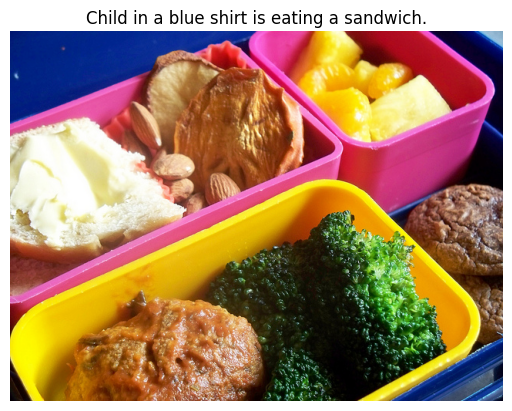

In [126]:
# Load the correct COCO-trained CLIP checkpoint
checkpoint = torch.load('CLIP_ckpts/model_L.pt', map_location=device)
model.load_state_dict(checkpoint, strict=False)
model.eval()

# Use same images
img1 = Image.open(image_path + './000000000030.jpg')
img2 = Image.open(image_path + './000000000009.jpg')

temperature = 1.0
for img in [img1, img2]:
    with torch.no_grad():
        caption, _ = model(img, temperature)
    plt.imshow(img)
    plt.title(caption)
    plt.axis("off")
    plt.show()

The large CLIP model trained on the COCO dataset performs slightly better than the small and large models. It generates captions that are more related to the actual image content. Even though it is imperfect, it is more concise and consistent. It shows that the model has learned a strong alignment between visual features and natural language from its training.

To improve network performance, the model should be fine-tuned on more diverse pairs from the target dataset. The training process may need more regularisation or retuning of decoding strategies. Decoding strategies like beam search or lower temperature can help reduce randomness in captions. Regularisation techniques such as dropout and learning rate scheduling can prevent overfitting. 


##### Now try on the CLIP fine-tuned on High-Level dataset. 

The High-Level (HL) dataset aligns object-centric descriptions from COCO with high-level descriptions crowdsourced along 3 axes: scene, action, rationale.

The HL dataset contains 14997 images from COCO and a total of 134973 crowdsourced captions (3 captions for each axis) aligned with ~749984 object-centric captions from COCO.

https://huggingface.co/datasets/michelecafagna26/hl

In [127]:
#run these to install CLIPClap - fine tuned on COCO

!pip install git+https://github.com/michelecafagna26/CLIPCap.git

!git lfs install 
!git clone https://huggingface.co/michelecafagna26/clipcap-base-captioning-ft-hl-scenes

  Cloning https://github.com/michelecafagna26/CLIPCap.git to /private/var/folders/l2/ywnjs44s40s1str7m8_h1nch0000gn/T/pip-req-build-vthnz8tp
  Running command git clone --filter=blob:none --quiet https://github.com/michelecafagna26/CLIPCap.git /private/var/folders/l2/ywnjs44s40s1str7m8_h1nch0000gn/T/pip-req-build-vthnz8tp
  Resolved https://github.com/michelecafagna26/CLIPCap.git to commit 545c5574fee8e3a56dec3e5c3f86388269a06f1d
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP (to revision main) to /private/var/folders/l2/ywnjs44s40s1str7m8_h1nch0000gn/T/pip-install-6rxf7fwu/clip_23a734f414e049778275841963023caf
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP /private/var/folders/l2/ywnjs44s40s1str7m8_h1nch0000gn/T/pip-install-6rxf7fwu/clip_23a734f414e049778275841963023caf
  Resolved https://github.com/openai/CLIP to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
     ━━━━━

In [ ]:
from clipcap import ClipCaptionModel
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import clip
import requests


model_path = "clipcap-base-captioning-ft-hl-scenes/pytorch_model.pt"

# load clip
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
prefix_length = 10

# load ClipCap
model = ClipCaptionModel(prefix_length, tokenizer=tokenizer)
model.from_pretrained(model_path)
model = model.eval()
model = model.to(device)


100%|███████████████████████████████████████| 338M/338M [00:19<00:00, 18.0MiB/s]
/Users/natalieleung/miniforge3/envs/nat/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


(-0.5, 499.5, 333.5, -0.5)

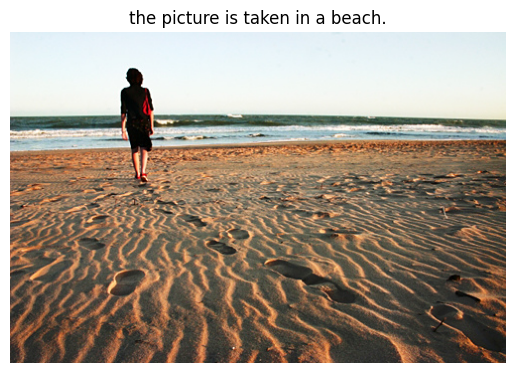

In [135]:
raw_image = Image.open('Flickr8k/Images/260828892_7925d27865.jpg').convert('RGB')
# extract the prefix
img = preprocess(raw_image).unsqueeze(0).to(device)
with torch.no_grad():
    prefix = clip_model.encode_image(img).to(
        device, dtype=torch.float32
    )
    prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)

# generate the caption   
caption = model.generate_beam(embed=prefix_embed)[0]

plt.imshow(raw_image)
plt.title(caption)
plt.axis("off")

(-0.5, 639.5, 427.5, -0.5)

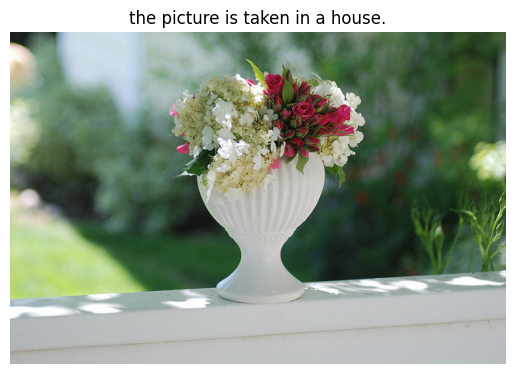

In [136]:
raw_image = Image.open(image_path + './000000000030.jpg').convert('RGB')
# extract the prefix
img = preprocess(raw_image).unsqueeze(0).to(device)
with torch.no_grad():
    prefix = clip_model.encode_image(img).to(
        device, dtype=torch.float32
    )
    prefix_embed = model.clip_project(prefix).reshape(1, prefix_length, -1)

# generate the caption   
caption = model.generate_beam(embed=prefix_embed)[0]

plt.imshow(raw_image)
plt.title(caption)
plt.axis("off")

The CLIP model fine-tuned on the High-Level dataset produces more abstract and related descriptions compared to the other models. For example, captions like “the picture is taken on a beach” and “the picture is taken on a house” show a broader understanding of the scene context instead of describing the objects. The descriptions are also grammatically correct; it shows that the model is effective at generalising to more semantic captions and understanding more details of the image.

<Your answer here>

##### Thank you for completing the practical assessment - if you have any question, please ask on teams channel or attend lab sessions on Wednesdays and Thursdays.